In [24]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [25]:
L = 7 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [26]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
        0.         |2 2 2 2 2 2 2>           2186  
        1.         |2 2 2 2 2 2 1>           2185  
        2.         |2 2 2 2 2 2 0>           2184  
        3.         |2 2 2 2 2 1 2>           2183  
        4.         |2 2 2 2 2 1 1>           2182  
        5.         |2 2 2 2 2 1 0>           2181  
        6.         |2 2 2 2 2 0 2>           2180  
        7.         |2 2 2 2 2 0 1>           2179  
        8.         |2 2 2 2 2 0 0>           2178  
        9.         |2 2 2 2 1 2 2>           2177  
       10.         |2 2 2 2 1 2 1>           2176  
       11.         |2 2 2 2 1 2 0>           2175  
       12.         |2 2 2 2 1 1 2>           2174  
       13.         |2 2 2 2 1 1 1>           2173  
       14.         |2 2 2 2 1 1 0>           2172  
       15.         |2 2 2 2 1 0 2>           2171  
       16.         |2 2 2 2 1 0 1>           2170  
       17.         |2 2 2 2 1 0 0>           21

In [27]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [28]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [29]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [30]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [31]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [32]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [33]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [34]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [35]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [36]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-1.43920377 -0.43399733 -0.32159336]


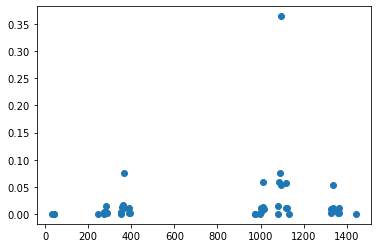

In [37]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [38]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [39]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full

In [40]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2
    
    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full




In [41]:
%time exp_gate_der(0,np.pi/3)

CPU times: user 7.33 ms, sys: 0 ns, total: 7.33 ms
Wall time: 6.3 ms


<2187x2187 sparse matrix of type '<class 'numpy.complex128'>'
	with 2916 stored elements in COOrdinate format>

In [42]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [43]:
def R(i,theta):
    
    if i%15 == 0:
        return(exp_gate(0,theta))

    if i%15 == 1:
        return(exp_gate(1,theta))

    if i%15 == 2:
        return(exp_gate(2,theta))

    if i%15 == 3:
        return(exp_gate(3,theta))
    
    if i%15 == 4:
        return(exp_gate(4,theta))

    if i%15 == 5:
        return(exp_gate(5,theta))

    if i%15 == 6:
        return(rot_sigma_e(0,1,0,theta))


    if i%15 == 7:
        return(rot_sigma_e(0,2,0,theta))

    
    if i%15 == 8:
        return(rot_sigma_e(1,2,np.pi/2,theta))

    
    if i%15 == 9:
        return(rot_sigma_o(0,1,0,theta))


    if i%15 == 10:
        return(rot_sigma_o(0,2,0,theta))

    
    if i%15 == 11:
        return(rot_sigma_o(1,2,np.pi/2,theta))

    if i%15 == 12:
        return(rot_sigma_r(0,1,0,theta))


    if i%15 == 13:
        return(rot_sigma_r(0,2,0,theta))

    
    if i%15 == 14:
        return(rot_sigma_r(1,2,np.pi/2,theta))
        

def S(i,theta):
    
    if i%15 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%15 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
    if i%15 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,theta).T.conj())

    if i%15 == 3:
        return(exp_gate_der(3,theta)@exp_gate(3,theta).T.conj())
    
    if i%15 == 4:
        return(exp_gate_der(4,theta)@exp_gate(4,theta).T.conj())

    if i%15 == 5:
        return(exp_gate_der(5,theta)@exp_gate(5,theta).T.conj())

    if i%15 == 6:
        return(-1j*sigma_e(0,1,0))

    
    if i%15 == 7:
        return(-1j*sigma_e(0,2,0))

    
    if i%15 == 8:
        return(-1j*sigma_e(1,2,np.pi/2))
     
    if i%15 == 9:
        return(-1j*sigma_o(0,1,0))

    
    if i%15 == 10:
        return(-1j*sigma_o(0,2,0))

    
    if i%15 == 11:
        return(-1j*sigma_o(1,2,np.pi/2))

     
    if i%15 == 12:
        return(-1j*sigma_r(0,1,0))

    
    if i%15 == 13:
        return(-1j*sigma_r(0,2,0))
    

    if i%15 == 14:
        return(-1j*sigma_r(1,2,np.pi/2))

In [44]:
coeff = 15
stepp = 350
t_final = 35

In [45]:
expt_value = []
energyy = []

time_domain = np.linspace(0, t_final, stepp)

Y = []

In [46]:
for kkk in range(3):
    
    N=kkk+1
    start_point = np.random.rand(coeff*N)

    matr = full_ham_matrix.toarray()
    B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
    psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s2 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

    def rhs(t,theta):

        print(datetime.datetime.now())
        for k in range(coeff*N):
            B[k] = R(k,theta[k])

        psi_b = psi_0
        for k in range(coeff*N):
            psi_b = B[coeff*N-1-k]@psi_b
        for i in range(L+1):
            psi_b = (Proj[i]+Proj_0[i])@psi_b
        norm_b = np.sqrt(np.real(np.conj(psi_b)@psi_b))
        psi_b = psi_b/norm_b



        psi_conj_b = np.conj(psi_b)

        print("start",datetime.datetime.now())

        for k in range(coeff*N):
            B[k] = S(k,theta[k])@R(k,theta[k])
            psi_d[k] = psi_0
            for i in range(coeff*N):
                psi_d[k] = B[coeff*N-1-i]@psi_d[k]
            B[k] = R(k,theta[k])

        print("stop_reduce",datetime.datetime.now())

        psi_conj_d = np.conj(psi_d)


        for k in range(coeff*N):
            for i in range(L+1):
                psi_d_1[k] = (Proj[i]+Proj_0[i])@psi_d[k]  
            psi_d_s1[k] = psi_d_1[k]/norm_b
            psi_d_s2[k] = -psi_b*(psi_conj_d[k]@psi_b+psi_conj_b@psi_d[k])
            psi_d[k] = psi_d_s1[k]+psi_d_s2[k]

        psi_conj_d = np.conj(psi_d)




        X = np.zeros((coeff*N,coeff*N),dtype = complex)
        Y = np.zeros(coeff*N,dtype = complex)


        X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

        Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)

        XX = np.einsum("il,l->i",psi_conj_d,psi_b)

        YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)

        YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
        YY = YY_1*YY_2
        XX = np.outer(XX,XX)
        X_r = 2*np.real(X+XX)
        Y_i = 2*np.real(Y+YY)
        result = -np.linalg.pinv(X_r,rcond = 1e-9)@Y_i
        print(datetime.datetime.now())

        print(t)

        return result

    # RK-4 method
    def rk4(x0,y0,xn,n):
        global Y

        # Calculating step size
        h = (xn-x0)/n

        #print('\n--------SOLUTION--------')
        #print('-------------------------')    
        #print('x0\ty0\tyn')
        #print('-------------------------')
        for i in range(n):
            k1 = h * (rhs(x0, y0))
            k2 = h * (rhs((x0+h/2), (y0+k1/2)))
            k3 = h * (rhs((x0+h/2), (y0+k2/2)))
            k4 = h * (rhs((x0+h), (y0+k3)))
            k = (k1+2*k2+2*k3+k4)/6
            yn = y0 + k
            #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
            #print('-------------------------')
            y0 = yn
            x0 = x0+h
            Y.append(y0)

        #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

    # Inputs
    #print('Enter initial conditions:')
    #x0 = float(input('x0 = '))
    #y0 = float(input('y0 = '))

    #print('Enter calculation point: ')
    #xn = float(input('xn = '))

    #print('Enter number of steps:')
    #step = int(input('Number of steps = '))

    # RK4 method call
    #start_point = 0.001*np.ones(coeff*N)




    Y = []
    #start_point = np.zeros(coeff*N)

    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])


        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-16 10:37:24.872712
start 2022-08-16 10:37:24.984038
stop_reduce 2022-08-16 10:37:25.677569
2022-08-16 10:37:25.989889
0
2022-08-16 10:37:25.989996
start 2022-08-16 10:37:26.135070
stop_reduce 2022-08-16 10:37:26.904387
2022-08-16 10:37:27.279512
0.05
2022-08-16 10:37:27.279624
start 2022-08-16 10:37:27.437755
stop_reduce 2022-08-16 10:37:28.253643
2022-08-16 10:37:28.576405
0.05
2022-08-16 10:37:28.576516
start 2022-08-16 10:37:28.705980
stop_reduce 2022-08-16 10:37:29.433182
2022-08-16 10:37:29.783291
0.1
2022-08-16 10:37:29.783479
start 2022-08-16 10:37:29.935163
stop_reduce 2022-08-16 10:37:30.784642
2022-08-16 10:37:31.126529
0.1
2022-08-16 10:37:31.126657
start 2022-08-16 10:37:31.278168
stop_reduce 2022-08-16 10:37:32.118937
2022-08-16 10:37:32.449253
0.15000000000000002
2022-08-16 10:37:32.449383
start 2022-08-16 10:37:32.594257
stop_reduce 2022-08-16 10:37:33.417125
2022-08-16 10:37:33.862354
0.15000000000000002
2022-08-16 10:37:33.862485
start 2022-08-16 10:37:34.00687

stop_reduce 2022-08-16 10:38:40.319989
2022-08-16 10:38:40.625712
1.5000000000000002
2022-08-16 10:38:40.625840
start 2022-08-16 10:38:40.762729
stop_reduce 2022-08-16 10:38:41.545989
2022-08-16 10:38:41.849945
1.5500000000000003
2022-08-16 10:38:41.850457
start 2022-08-16 10:38:41.978271
stop_reduce 2022-08-16 10:38:42.691055
2022-08-16 10:38:42.983008
1.5500000000000003
2022-08-16 10:38:42.983515
start 2022-08-16 10:38:43.110739
stop_reduce 2022-08-16 10:38:43.841426
2022-08-16 10:38:44.141367
1.6000000000000003
2022-08-16 10:38:44.141844
start 2022-08-16 10:38:44.269280
stop_reduce 2022-08-16 10:38:45.052634
2022-08-16 10:38:45.349564
1.6000000000000003
2022-08-16 10:38:45.350044
start 2022-08-16 10:38:45.483300
stop_reduce 2022-08-16 10:38:46.199482
2022-08-16 10:38:46.488711
1.6500000000000004
2022-08-16 10:38:46.489234
start 2022-08-16 10:38:46.615923
stop_reduce 2022-08-16 10:38:47.350291
2022-08-16 10:38:47.649251
1.6500000000000004
2022-08-16 10:38:47.649719
start 2022-08-16 1

stop_reduce 2022-08-16 10:39:46.866841
2022-08-16 10:39:47.218273
2.950000000000001
2022-08-16 10:39:47.218386
start 2022-08-16 10:39:47.351283
stop_reduce 2022-08-16 10:39:48.090521
2022-08-16 10:39:48.377139
2.950000000000001
2022-08-16 10:39:48.377642
start 2022-08-16 10:39:48.505834
stop_reduce 2022-08-16 10:39:49.220267
2022-08-16 10:39:49.538522
3.0000000000000013
2022-08-16 10:39:49.538659
start 2022-08-16 10:39:49.673860
stop_reduce 2022-08-16 10:39:50.396048
2022-08-16 10:39:50.701407
3.0000000000000013
2022-08-16 10:39:50.701521
start 2022-08-16 10:39:50.832669
stop_reduce 2022-08-16 10:39:51.553772
2022-08-16 10:39:51.841734
3.050000000000001
2022-08-16 10:39:51.842208
start 2022-08-16 10:39:51.970286
stop_reduce 2022-08-16 10:39:52.684729
2022-08-16 10:39:52.975590
3.050000000000001
2022-08-16 10:39:52.975933
start 2022-08-16 10:39:53.110680
stop_reduce 2022-08-16 10:39:53.856228
2022-08-16 10:39:54.210120
3.1000000000000014
2022-08-16 10:39:54.210241
start 2022-08-16 10:39

stop_reduce 2022-08-16 10:40:53.692681
2022-08-16 10:40:53.988846
4.3500000000000005
2022-08-16 10:40:53.988961
start 2022-08-16 10:40:54.119653
stop_reduce 2022-08-16 10:40:54.832245
2022-08-16 10:40:55.118282
4.4
2022-08-16 10:40:55.118815
start 2022-08-16 10:40:55.247525
stop_reduce 2022-08-16 10:40:55.983299
2022-08-16 10:40:56.276396
4.4
2022-08-16 10:40:56.276510
start 2022-08-16 10:40:56.406111
stop_reduce 2022-08-16 10:40:57.190956
2022-08-16 10:40:57.500512
4.45
2022-08-16 10:40:57.500615
start 2022-08-16 10:40:57.629781
stop_reduce 2022-08-16 10:40:58.339312
2022-08-16 10:40:58.628563
4.45
2022-08-16 10:40:58.628670
start 2022-08-16 10:40:58.757882
stop_reduce 2022-08-16 10:40:59.536273
2022-08-16 10:40:59.870917
4.5
2022-08-16 10:40:59.871061
start 2022-08-16 10:41:00.021034
stop_reduce 2022-08-16 10:41:00.861442
2022-08-16 10:41:01.173407
4.5
2022-08-16 10:41:01.173526
start 2022-08-16 10:41:01.305031
stop_reduce 2022-08-16 10:41:02.024653
2022-08-16 10:41:02.313284
4.55
20

stop_reduce 2022-08-16 10:42:02.057864
2022-08-16 10:42:02.395284
5.799999999999995
2022-08-16 10:42:02.395405
start 2022-08-16 10:42:02.539178
stop_reduce 2022-08-16 10:42:03.313042
2022-08-16 10:42:03.659273
5.849999999999995
2022-08-16 10:42:03.659387
start 2022-08-16 10:42:03.797722
stop_reduce 2022-08-16 10:42:04.565415
2022-08-16 10:42:04.875684
5.849999999999995
2022-08-16 10:42:04.875773
start 2022-08-16 10:42:05.021175
stop_reduce 2022-08-16 10:42:05.795165
2022-08-16 10:42:06.114607
5.899999999999995
2022-08-16 10:42:06.114733
start 2022-08-16 10:42:06.254036
stop_reduce 2022-08-16 10:42:07.013503
2022-08-16 10:42:07.377896
5.899999999999995
2022-08-16 10:42:07.378329
start 2022-08-16 10:42:07.537525
stop_reduce 2022-08-16 10:42:08.397133
2022-08-16 10:42:08.746172
5.949999999999995
2022-08-16 10:42:08.746282
start 2022-08-16 10:42:08.902919
stop_reduce 2022-08-16 10:42:09.741217
2022-08-16 10:42:10.090398
5.949999999999995
2022-08-16 10:42:10.090531
start 2022-08-16 10:42:10

stop_reduce 2022-08-16 10:42:59.977136
2022-08-16 10:43:00.224747
7.24999999999999
2022-08-16 10:43:00.224853
start 2022-08-16 10:43:00.337311
stop_reduce 2022-08-16 10:43:00.930979
2022-08-16 10:43:01.163326
7.24999999999999
2022-08-16 10:43:01.163400
start 2022-08-16 10:43:01.273271
stop_reduce 2022-08-16 10:43:01.987685
2022-08-16 10:43:02.307012
7.29999999999999
2022-08-16 10:43:02.307140
start 2022-08-16 10:43:02.442895
stop_reduce 2022-08-16 10:43:03.191656
2022-08-16 10:43:03.491032
7.29999999999999
2022-08-16 10:43:03.491127
start 2022-08-16 10:43:03.612604
stop_reduce 2022-08-16 10:43:04.294287
2022-08-16 10:43:04.565726
7.34999999999999
2022-08-16 10:43:04.565808
start 2022-08-16 10:43:04.671970
stop_reduce 2022-08-16 10:43:05.275068
2022-08-16 10:43:05.541678
7.34999999999999
2022-08-16 10:43:05.541773
start 2022-08-16 10:43:05.649392
stop_reduce 2022-08-16 10:43:06.224939
2022-08-16 10:43:06.450647
7.39999999999999
2022-08-16 10:43:06.450742
start 2022-08-16 10:43:06.553292

stop_reduce 2022-08-16 10:43:54.083729
2022-08-16 10:43:54.387119
8.649999999999986
2022-08-16 10:43:54.387245
start 2022-08-16 10:43:54.536211
stop_reduce 2022-08-16 10:43:55.382803
2022-08-16 10:43:55.693101
8.699999999999985
2022-08-16 10:43:55.693193
start 2022-08-16 10:43:55.821181
stop_reduce 2022-08-16 10:43:56.555600
2022-08-16 10:43:56.853543
8.699999999999985
2022-08-16 10:43:56.853654
start 2022-08-16 10:43:56.982003
stop_reduce 2022-08-16 10:43:57.647872
2022-08-16 10:43:57.887758
8.749999999999986
2022-08-16 10:43:57.887840
start 2022-08-16 10:43:57.991665
stop_reduce 2022-08-16 10:43:58.584044
2022-08-16 10:43:58.856794
8.749999999999986
2022-08-16 10:43:58.856876
start 2022-08-16 10:43:58.985911
stop_reduce 2022-08-16 10:43:59.695321
2022-08-16 10:43:59.981533
8.799999999999985
2022-08-16 10:43:59.981629
start 2022-08-16 10:44:00.109425
stop_reduce 2022-08-16 10:44:00.722538
2022-08-16 10:44:00.999980
8.799999999999985
2022-08-16 10:44:01.000086
start 2022-08-16 10:44:01

stop_reduce 2022-08-16 10:44:50.412957
2022-08-16 10:44:50.672326
10.09999999999998
2022-08-16 10:44:50.672625
start 2022-08-16 10:44:50.774897
stop_reduce 2022-08-16 10:44:51.363498
2022-08-16 10:44:51.640209
10.09999999999998
2022-08-16 10:44:51.640319
start 2022-08-16 10:44:51.757954
stop_reduce 2022-08-16 10:44:52.425663
2022-08-16 10:44:52.699231
10.14999999999998
2022-08-16 10:44:52.699344
start 2022-08-16 10:44:52.817966
stop_reduce 2022-08-16 10:44:53.463427
2022-08-16 10:44:53.725478
10.14999999999998
2022-08-16 10:44:53.725562
start 2022-08-16 10:44:53.851382
stop_reduce 2022-08-16 10:44:54.511945
2022-08-16 10:44:54.757066
10.19999999999998
2022-08-16 10:44:54.757155
start 2022-08-16 10:44:54.867324
stop_reduce 2022-08-16 10:44:55.464782
2022-08-16 10:44:55.704218
10.19999999999998
2022-08-16 10:44:55.704339
start 2022-08-16 10:44:55.826200
stop_reduce 2022-08-16 10:44:56.531430
2022-08-16 10:44:56.784993
10.24999999999998
2022-08-16 10:44:56.785086
start 2022-08-16 10:44:56

stop_reduce 2022-08-16 10:45:43.094953
2022-08-16 10:45:43.320503
11.499999999999975
2022-08-16 10:45:43.320633
start 2022-08-16 10:45:43.425424
stop_reduce 2022-08-16 10:45:43.996624
2022-08-16 10:45:44.223129
11.549999999999976
2022-08-16 10:45:44.223220
start 2022-08-16 10:45:44.326892
stop_reduce 2022-08-16 10:45:44.896232
2022-08-16 10:45:45.122297
11.549999999999976
2022-08-16 10:45:45.122439
start 2022-08-16 10:45:45.226551
stop_reduce 2022-08-16 10:45:45.802143
2022-08-16 10:45:46.028533
11.599999999999975
2022-08-16 10:45:46.028631
start 2022-08-16 10:45:46.131448
stop_reduce 2022-08-16 10:45:46.702203
2022-08-16 10:45:46.926906
11.599999999999975
2022-08-16 10:45:46.926988
start 2022-08-16 10:45:47.031363
stop_reduce 2022-08-16 10:45:47.602378
2022-08-16 10:45:47.826832
11.649999999999975
2022-08-16 10:45:47.826943
start 2022-08-16 10:45:47.930295
stop_reduce 2022-08-16 10:45:48.498462
2022-08-16 10:45:48.722758
11.649999999999975
2022-08-16 10:45:48.722838
start 2022-08-16 1

stop_reduce 2022-08-16 10:46:36.261524
2022-08-16 10:46:36.486785
12.94999999999997
2022-08-16 10:46:36.486881
start 2022-08-16 10:46:36.590481
stop_reduce 2022-08-16 10:46:37.164604
2022-08-16 10:46:37.391044
12.94999999999997
2022-08-16 10:46:37.391147
start 2022-08-16 10:46:37.494675
stop_reduce 2022-08-16 10:46:38.064064
2022-08-16 10:46:38.290486
12.99999999999997
2022-08-16 10:46:38.290597
start 2022-08-16 10:46:38.394098
stop_reduce 2022-08-16 10:46:38.965891
2022-08-16 10:46:39.192956
12.99999999999997
2022-08-16 10:46:39.193060
start 2022-08-16 10:46:39.296196
stop_reduce 2022-08-16 10:46:39.863331
2022-08-16 10:46:40.090440
13.04999999999997
2022-08-16 10:46:40.090530
start 2022-08-16 10:46:40.194499
stop_reduce 2022-08-16 10:46:40.764482
2022-08-16 10:46:40.994391
13.04999999999997
2022-08-16 10:46:40.994493
start 2022-08-16 10:46:41.099911
stop_reduce 2022-08-16 10:46:41.670502
2022-08-16 10:46:41.893927
13.09999999999997
2022-08-16 10:46:41.894041
start 2022-08-16 10:46:41

stop_reduce 2022-08-16 10:47:27.949050
2022-08-16 10:47:28.175265
14.349999999999966
2022-08-16 10:47:28.175343
start 2022-08-16 10:47:28.285117
stop_reduce 2022-08-16 10:47:28.871960
2022-08-16 10:47:29.102232
14.399999999999965
2022-08-16 10:47:29.102346
start 2022-08-16 10:47:29.206592
stop_reduce 2022-08-16 10:47:29.789985
2022-08-16 10:47:30.015826
14.399999999999965
2022-08-16 10:47:30.015932
start 2022-08-16 10:47:30.119381
stop_reduce 2022-08-16 10:47:30.708857
2022-08-16 10:47:30.937812
14.449999999999966
2022-08-16 10:47:30.937901
start 2022-08-16 10:47:31.042048
stop_reduce 2022-08-16 10:47:31.620459
2022-08-16 10:47:31.848248
14.449999999999966
2022-08-16 10:47:31.848352
start 2022-08-16 10:47:31.951736
stop_reduce 2022-08-16 10:47:32.536409
2022-08-16 10:47:32.766111
14.499999999999964
2022-08-16 10:47:32.766204
start 2022-08-16 10:47:32.872673
stop_reduce 2022-08-16 10:47:33.450728
2022-08-16 10:47:33.686394
14.499999999999964
2022-08-16 10:47:33.686477
start 2022-08-16 1

stop_reduce 2022-08-16 10:48:20.319470
2022-08-16 10:48:20.547548
15.79999999999996
2022-08-16 10:48:20.547642
start 2022-08-16 10:48:20.650355
stop_reduce 2022-08-16 10:48:21.231801
2022-08-16 10:48:21.459651
15.79999999999996
2022-08-16 10:48:21.459755
start 2022-08-16 10:48:21.564579
stop_reduce 2022-08-16 10:48:22.148118
2022-08-16 10:48:22.377542
15.84999999999996
2022-08-16 10:48:22.377623
start 2022-08-16 10:48:22.481977
stop_reduce 2022-08-16 10:48:23.055434
2022-08-16 10:48:23.290791
15.84999999999996
2022-08-16 10:48:23.290892
start 2022-08-16 10:48:23.395133
stop_reduce 2022-08-16 10:48:23.969334
2022-08-16 10:48:24.205833
15.89999999999996
2022-08-16 10:48:24.205916
start 2022-08-16 10:48:24.310525
stop_reduce 2022-08-16 10:48:24.888276
2022-08-16 10:48:25.117654
15.89999999999996
2022-08-16 10:48:25.117733
start 2022-08-16 10:48:25.228486
stop_reduce 2022-08-16 10:48:25.820594
2022-08-16 10:48:26.046795
15.94999999999996
2022-08-16 10:48:26.046876
start 2022-08-16 10:48:26

stop_reduce 2022-08-16 10:49:12.372932
2022-08-16 10:49:12.600740
17.199999999999974
2022-08-16 10:49:12.600817
start 2022-08-16 10:49:12.705745
stop_reduce 2022-08-16 10:49:13.283158
2022-08-16 10:49:13.510691
17.249999999999975
2022-08-16 10:49:13.510775
start 2022-08-16 10:49:13.616133
stop_reduce 2022-08-16 10:49:14.192911
2022-08-16 10:49:14.419402
17.249999999999975
2022-08-16 10:49:14.419482
start 2022-08-16 10:49:14.524341
stop_reduce 2022-08-16 10:49:15.105534
2022-08-16 10:49:15.336163
17.299999999999976
2022-08-16 10:49:15.336275
start 2022-08-16 10:49:15.441836
stop_reduce 2022-08-16 10:49:16.021501
2022-08-16 10:49:16.248618
17.299999999999976
2022-08-16 10:49:16.248733
start 2022-08-16 10:49:16.353047
stop_reduce 2022-08-16 10:49:16.930252
2022-08-16 10:49:17.157970
17.349999999999977
2022-08-16 10:49:17.158053
start 2022-08-16 10:49:17.262306
stop_reduce 2022-08-16 10:49:17.845877
2022-08-16 10:49:18.074244
17.349999999999977
2022-08-16 10:49:18.074337
start 2022-08-16 1

stop_reduce 2022-08-16 10:50:04.278858
2022-08-16 10:50:04.522863
18.649999999999995
2022-08-16 10:50:04.522965
start 2022-08-16 10:50:04.628216
stop_reduce 2022-08-16 10:50:05.199183
2022-08-16 10:50:05.424639
18.649999999999995
2022-08-16 10:50:05.424753
start 2022-08-16 10:50:05.529038
stop_reduce 2022-08-16 10:50:06.100556
2022-08-16 10:50:06.325580
18.699999999999996
2022-08-16 10:50:06.325660
start 2022-08-16 10:50:06.430229
stop_reduce 2022-08-16 10:50:07.003631
2022-08-16 10:50:07.231166
18.699999999999996
2022-08-16 10:50:07.231255
start 2022-08-16 10:50:07.334451
stop_reduce 2022-08-16 10:50:07.908138
2022-08-16 10:50:08.131900
18.749999999999996
2022-08-16 10:50:08.131982
start 2022-08-16 10:50:08.235119
stop_reduce 2022-08-16 10:50:08.805621
2022-08-16 10:50:09.030803
18.749999999999996
2022-08-16 10:50:09.030927
start 2022-08-16 10:50:09.134519
stop_reduce 2022-08-16 10:50:09.704945
2022-08-16 10:50:09.932689
18.799999999999997
2022-08-16 10:50:09.932954
start 2022-08-16 1

stop_reduce 2022-08-16 10:50:56.844980
2022-08-16 10:50:57.079482
20.100000000000016
2022-08-16 10:50:57.079595
start 2022-08-16 10:50:57.183101
stop_reduce 2022-08-16 10:50:57.763567
2022-08-16 10:50:57.993597
20.100000000000016
2022-08-16 10:50:57.993753
start 2022-08-16 10:50:58.104905
stop_reduce 2022-08-16 10:50:58.675624
2022-08-16 10:50:58.901935
20.150000000000016
2022-08-16 10:50:58.902018
start 2022-08-16 10:50:59.006307
stop_reduce 2022-08-16 10:50:59.581935
2022-08-16 10:50:59.809274
20.150000000000016
2022-08-16 10:50:59.809366
start 2022-08-16 10:50:59.913625
stop_reduce 2022-08-16 10:51:00.489306
2022-08-16 10:51:00.717061
20.200000000000017
2022-08-16 10:51:00.717148
start 2022-08-16 10:51:00.819619
stop_reduce 2022-08-16 10:51:01.400818
2022-08-16 10:51:01.633068
20.200000000000017
2022-08-16 10:51:01.633174
start 2022-08-16 10:51:01.737757
stop_reduce 2022-08-16 10:51:02.312439
2022-08-16 10:51:02.539629
20.250000000000018
2022-08-16 10:51:02.539728
start 2022-08-16 1

stop_reduce 2022-08-16 10:51:48.524629
2022-08-16 10:51:48.752396
21.500000000000036
2022-08-16 10:51:48.752661
start 2022-08-16 10:51:48.855845
stop_reduce 2022-08-16 10:51:49.427575
2022-08-16 10:51:49.656376
21.550000000000036
2022-08-16 10:51:49.656470
start 2022-08-16 10:51:49.760050
stop_reduce 2022-08-16 10:51:50.330384
2022-08-16 10:51:50.554898
21.550000000000036
2022-08-16 10:51:50.554976
start 2022-08-16 10:51:50.658000
stop_reduce 2022-08-16 10:51:51.228966
2022-08-16 10:51:51.452573
21.600000000000037
2022-08-16 10:51:51.452697
start 2022-08-16 10:51:51.556495
stop_reduce 2022-08-16 10:51:52.126856
2022-08-16 10:51:52.353885
21.600000000000037
2022-08-16 10:51:52.353976
start 2022-08-16 10:51:52.457630
stop_reduce 2022-08-16 10:51:53.026061
2022-08-16 10:51:53.252041
21.650000000000038
2022-08-16 10:51:53.252117
start 2022-08-16 10:51:53.354971
stop_reduce 2022-08-16 10:51:53.923965
2022-08-16 10:51:54.150456
21.650000000000038
2022-08-16 10:51:54.150530
start 2022-08-16 1

stop_reduce 2022-08-16 10:52:40.387418
2022-08-16 10:52:40.615756
22.950000000000056
2022-08-16 10:52:40.615840
start 2022-08-16 10:52:40.719593
stop_reduce 2022-08-16 10:52:41.290138
2022-08-16 10:52:41.518503
22.950000000000056
2022-08-16 10:52:41.518579
start 2022-08-16 10:52:41.622391
stop_reduce 2022-08-16 10:52:42.192737
2022-08-16 10:52:42.419725
23.000000000000057
2022-08-16 10:52:42.419836
start 2022-08-16 10:52:42.522860
stop_reduce 2022-08-16 10:52:43.094984
2022-08-16 10:52:43.320204
23.000000000000057
2022-08-16 10:52:43.320285
start 2022-08-16 10:52:43.424734
stop_reduce 2022-08-16 10:52:43.996577
2022-08-16 10:52:44.224552
23.050000000000058
2022-08-16 10:52:44.224631
start 2022-08-16 10:52:44.326903
stop_reduce 2022-08-16 10:52:44.905524
2022-08-16 10:52:45.136919
23.050000000000058
2022-08-16 10:52:45.137001
start 2022-08-16 10:52:45.242553
stop_reduce 2022-08-16 10:52:45.818315
2022-08-16 10:52:46.045346
23.10000000000006
2022-08-16 10:52:46.045431
start 2022-08-16 10

stop_reduce 2022-08-16 10:53:31.852530
2022-08-16 10:53:32.070612
24.350000000000076
2022-08-16 10:53:32.070687
start 2022-08-16 10:53:32.160142
stop_reduce 2022-08-16 10:53:32.670677
2022-08-16 10:53:32.893409
24.400000000000077
2022-08-16 10:53:32.893500
start 2022-08-16 10:53:32.982190
stop_reduce 2022-08-16 10:53:33.492618
2022-08-16 10:53:33.710781
24.400000000000077
2022-08-16 10:53:33.710859
start 2022-08-16 10:53:33.799923
stop_reduce 2022-08-16 10:53:34.308294
2022-08-16 10:53:34.526076
24.450000000000077
2022-08-16 10:53:34.526153
start 2022-08-16 10:53:34.614500
stop_reduce 2022-08-16 10:53:35.121811
2022-08-16 10:53:35.340616
24.450000000000077
2022-08-16 10:53:35.340705
start 2022-08-16 10:53:35.428902
stop_reduce 2022-08-16 10:53:35.936898
2022-08-16 10:53:36.156352
24.500000000000078
2022-08-16 10:53:36.156453
start 2022-08-16 10:53:36.245604
stop_reduce 2022-08-16 10:53:36.755397
2022-08-16 10:53:36.973467
24.500000000000078
2022-08-16 10:53:36.973545
start 2022-08-16 1

stop_reduce 2022-08-16 10:54:22.824576
2022-08-16 10:54:23.055094
25.800000000000097
2022-08-16 10:54:23.055180
start 2022-08-16 10:54:23.157343
stop_reduce 2022-08-16 10:54:23.731942
2022-08-16 10:54:23.958892
25.800000000000097
2022-08-16 10:54:23.958985
start 2022-08-16 10:54:24.063097
stop_reduce 2022-08-16 10:54:24.632597
2022-08-16 10:54:24.857866
25.850000000000097
2022-08-16 10:54:24.857948
start 2022-08-16 10:54:24.960241
stop_reduce 2022-08-16 10:54:25.530268
2022-08-16 10:54:25.755421
25.850000000000097
2022-08-16 10:54:25.755524
start 2022-08-16 10:54:25.858309
stop_reduce 2022-08-16 10:54:26.431190
2022-08-16 10:54:26.657038
25.900000000000098
2022-08-16 10:54:26.657124
start 2022-08-16 10:54:26.760325
stop_reduce 2022-08-16 10:54:27.328777
2022-08-16 10:54:27.554563
25.900000000000098
2022-08-16 10:54:27.554673
start 2022-08-16 10:54:27.658319
stop_reduce 2022-08-16 10:54:28.228397
2022-08-16 10:54:28.453217
25.9500000000001
2022-08-16 10:54:28.453365
start 2022-08-16 10:

stop_reduce 2022-08-16 10:55:16.935476
2022-08-16 10:55:17.158605
27.200000000000117
2022-08-16 10:55:17.158689
start 2022-08-16 10:55:17.259780
stop_reduce 2022-08-16 10:55:17.814205
2022-08-16 10:55:18.040347
27.250000000000117
2022-08-16 10:55:18.040438
start 2022-08-16 10:55:18.142373
stop_reduce 2022-08-16 10:55:18.699368
2022-08-16 10:55:18.926291
27.250000000000117
2022-08-16 10:55:18.926365
start 2022-08-16 10:55:19.029029
stop_reduce 2022-08-16 10:55:19.604407
2022-08-16 10:55:19.841218
27.300000000000118
2022-08-16 10:55:19.841322
start 2022-08-16 10:55:19.945177
stop_reduce 2022-08-16 10:55:20.504172
2022-08-16 10:55:20.728955
27.300000000000118
2022-08-16 10:55:20.729028
start 2022-08-16 10:55:20.830157
stop_reduce 2022-08-16 10:55:21.384449
2022-08-16 10:55:21.610005
27.35000000000012
2022-08-16 10:55:21.610101
start 2022-08-16 10:55:21.712107
stop_reduce 2022-08-16 10:55:22.264726
2022-08-16 10:55:22.485626
27.35000000000012
2022-08-16 10:55:22.485698
start 2022-08-16 10:

stop_reduce 2022-08-16 10:56:24.406032
2022-08-16 10:56:24.770130
28.650000000000137
2022-08-16 10:56:24.770247
start 2022-08-16 10:56:24.923241
stop_reduce 2022-08-16 10:56:25.823122
2022-08-16 10:56:26.164375
28.650000000000137
2022-08-16 10:56:26.164490
start 2022-08-16 10:56:26.324050
stop_reduce 2022-08-16 10:56:27.171800
2022-08-16 10:56:27.536978
28.700000000000138
2022-08-16 10:56:27.537105
start 2022-08-16 10:56:27.701046
stop_reduce 2022-08-16 10:56:28.593456
2022-08-16 10:56:28.939264
28.700000000000138
2022-08-16 10:56:28.940171
start 2022-08-16 10:56:29.102774
stop_reduce 2022-08-16 10:56:30.014691
2022-08-16 10:56:30.367789
28.75000000000014
2022-08-16 10:56:30.368122
start 2022-08-16 10:56:30.538959
stop_reduce 2022-08-16 10:56:31.390127
2022-08-16 10:56:31.728888
28.75000000000014
2022-08-16 10:56:31.729003
start 2022-08-16 10:56:31.880537
stop_reduce 2022-08-16 10:56:32.730954
2022-08-16 10:56:33.105263
28.80000000000014
2022-08-16 10:56:33.105393
start 2022-08-16 10:5

stop_reduce 2022-08-16 10:57:31.775150
2022-08-16 10:57:32.025818
30.050000000000157
2022-08-16 10:57:32.026102
start 2022-08-16 10:57:32.137250
stop_reduce 2022-08-16 10:57:32.754447
2022-08-16 10:57:33.002084
30.100000000000158
2022-08-16 10:57:33.002190
start 2022-08-16 10:57:33.113283
stop_reduce 2022-08-16 10:57:33.728455
2022-08-16 10:57:33.974614
30.100000000000158
2022-08-16 10:57:33.974704
start 2022-08-16 10:57:34.085617
stop_reduce 2022-08-16 10:57:34.699992
2022-08-16 10:57:34.949017
30.15000000000016
2022-08-16 10:57:34.949098
start 2022-08-16 10:57:35.060437
stop_reduce 2022-08-16 10:57:35.678257
2022-08-16 10:57:35.927532
30.15000000000016
2022-08-16 10:57:35.927613
start 2022-08-16 10:57:36.039591
stop_reduce 2022-08-16 10:57:36.661153
2022-08-16 10:57:36.911031
30.20000000000016
2022-08-16 10:57:36.911131
start 2022-08-16 10:57:37.025482
stop_reduce 2022-08-16 10:57:37.666160
2022-08-16 10:57:37.920791
30.20000000000016
2022-08-16 10:57:37.920879
start 2022-08-16 10:57

stop_reduce 2022-08-16 10:58:28.128798
2022-08-16 10:58:28.382001
31.500000000000178
2022-08-16 10:58:28.382125
start 2022-08-16 10:58:28.496049
stop_reduce 2022-08-16 10:58:29.117945
2022-08-16 10:58:29.372246
31.500000000000178
2022-08-16 10:58:29.372353
start 2022-08-16 10:58:29.483872
stop_reduce 2022-08-16 10:58:30.103421
2022-08-16 10:58:30.353875
31.55000000000018
2022-08-16 10:58:30.353969
start 2022-08-16 10:58:30.466026
stop_reduce 2022-08-16 10:58:31.085366
2022-08-16 10:58:31.335052
31.55000000000018
2022-08-16 10:58:31.335138
start 2022-08-16 10:58:31.447234
stop_reduce 2022-08-16 10:58:32.066284
2022-08-16 10:58:32.318936
31.60000000000018
2022-08-16 10:58:32.319027
start 2022-08-16 10:58:32.430650
stop_reduce 2022-08-16 10:58:33.135567
2022-08-16 10:58:33.467927
31.60000000000018
2022-08-16 10:58:33.468068
start 2022-08-16 10:58:33.612877
stop_reduce 2022-08-16 10:58:34.432667
2022-08-16 10:58:34.788164
31.65000000000018
2022-08-16 10:58:34.788271
start 2022-08-16 10:58:

stop_reduce 2022-08-16 10:59:36.577835
2022-08-16 10:59:36.862844
32.9000000000002
2022-08-16 10:59:36.862952
start 2022-08-16 10:59:36.989300
stop_reduce 2022-08-16 10:59:37.692100
2022-08-16 10:59:37.948116
32.950000000000195
2022-08-16 10:59:37.948214
start 2022-08-16 10:59:38.061771
stop_reduce 2022-08-16 10:59:38.688374
2022-08-16 10:59:38.939555
32.950000000000195
2022-08-16 10:59:38.939644
start 2022-08-16 10:59:39.051150
stop_reduce 2022-08-16 10:59:39.666992
2022-08-16 10:59:39.928958
33.0000000000002
2022-08-16 10:59:39.929076
start 2022-08-16 10:59:40.053357
stop_reduce 2022-08-16 10:59:40.748815
2022-08-16 10:59:41.019707
33.0000000000002
2022-08-16 10:59:41.019797
start 2022-08-16 10:59:41.141752
stop_reduce 2022-08-16 10:59:41.866623
2022-08-16 10:59:42.205934
33.050000000000196
2022-08-16 10:59:42.206032
start 2022-08-16 10:59:42.355518
stop_reduce 2022-08-16 10:59:43.193927
2022-08-16 10:59:43.520762
33.050000000000196
2022-08-16 10:59:43.520878
start 2022-08-16 10:59:4

stop_reduce 2022-08-16 11:00:45.063264
2022-08-16 11:00:45.340195
34.350000000000215
2022-08-16 11:00:45.340313
start 2022-08-16 11:00:45.461049
stop_reduce 2022-08-16 11:00:46.140815
2022-08-16 11:00:46.417372
34.350000000000215
2022-08-16 11:00:46.417463
start 2022-08-16 11:00:46.558672
stop_reduce 2022-08-16 11:00:47.357429
2022-08-16 11:00:47.635453
34.40000000000022
2022-08-16 11:00:47.635554
start 2022-08-16 11:00:47.760490
stop_reduce 2022-08-16 11:00:48.554206
2022-08-16 11:00:48.877967
34.40000000000022
2022-08-16 11:00:48.878084
start 2022-08-16 11:00:49.012415
stop_reduce 2022-08-16 11:00:49.689399
2022-08-16 11:00:49.945507
34.450000000000216
2022-08-16 11:00:49.945594
start 2022-08-16 11:00:50.060605
stop_reduce 2022-08-16 11:00:50.690459
2022-08-16 11:00:50.942023
34.450000000000216
2022-08-16 11:00:50.942114
start 2022-08-16 11:00:51.054514
stop_reduce 2022-08-16 11:00:51.676394
2022-08-16 11:00:51.923399
34.50000000000022
2022-08-16 11:00:51.923498
start 2022-08-16 11:0

2022-08-16 11:02:48.501984
0.7999999999999999
2022-08-16 11:02:48.502300
start 2022-08-16 11:02:48.698372
stop_reduce 2022-08-16 11:02:49.815128
2022-08-16 11:02:50.253238
0.85
2022-08-16 11:02:50.253588
start 2022-08-16 11:02:50.450656
stop_reduce 2022-08-16 11:02:51.575412
2022-08-16 11:02:52.018258
0.85
2022-08-16 11:02:52.018624
start 2022-08-16 11:02:52.214688
stop_reduce 2022-08-16 11:02:53.329155
2022-08-16 11:02:53.775669
0.8999999999999999
2022-08-16 11:02:53.775989
start 2022-08-16 11:02:53.973085
stop_reduce 2022-08-16 11:02:55.090848
2022-08-16 11:02:55.535250
0.8999999999999999
2022-08-16 11:02:55.535622
start 2022-08-16 11:02:55.737998
stop_reduce 2022-08-16 11:02:56.867110
2022-08-16 11:02:57.310237
0.95
2022-08-16 11:02:57.310615
start 2022-08-16 11:02:57.507732
stop_reduce 2022-08-16 11:02:58.631990
2022-08-16 11:02:59.073860
0.95
2022-08-16 11:02:59.074232
start 2022-08-16 11:02:59.270217
stop_reduce 2022-08-16 11:03:00.388085
2022-08-16 11:03:00.833330
0.999999999999

2022-08-16 11:04:29.384892
2.2500000000000004
2022-08-16 11:04:29.385211
start 2022-08-16 11:04:29.583886
stop_reduce 2022-08-16 11:04:30.704300
2022-08-16 11:04:31.149919
2.3000000000000007
2022-08-16 11:04:31.150424
start 2022-08-16 11:04:31.347830
stop_reduce 2022-08-16 11:04:32.469318
2022-08-16 11:04:32.912144
2.3000000000000007
2022-08-16 11:04:32.912484
start 2022-08-16 11:04:33.110869
stop_reduce 2022-08-16 11:04:34.221632
2022-08-16 11:04:34.668667
2.3500000000000005
2022-08-16 11:04:34.668986
start 2022-08-16 11:04:34.872630
stop_reduce 2022-08-16 11:04:35.999266
2022-08-16 11:04:36.445260
2.3500000000000005
2022-08-16 11:04:36.445561
start 2022-08-16 11:04:36.643325
stop_reduce 2022-08-16 11:04:37.755508
2022-08-16 11:04:38.196629
2.400000000000001
2022-08-16 11:04:38.197136
start 2022-08-16 11:04:38.393877
stop_reduce 2022-08-16 11:04:39.504559
2022-08-16 11:04:39.946715
2.400000000000001
2022-08-16 11:04:39.947025
start 2022-08-16 11:04:40.144707
stop_reduce 2022-08-16 11:

stop_reduce 2022-08-16 11:06:09.231861
2022-08-16 11:06:09.667257
3.700000000000002
2022-08-16 11:06:09.667576
start 2022-08-16 11:06:09.864307
stop_reduce 2022-08-16 11:06:10.970989
2022-08-16 11:06:11.405141
3.700000000000002
2022-08-16 11:06:11.405526
start 2022-08-16 11:06:11.601935
stop_reduce 2022-08-16 11:06:12.705073
2022-08-16 11:06:13.136558
3.7500000000000018
2022-08-16 11:06:13.136941
start 2022-08-16 11:06:13.333014
stop_reduce 2022-08-16 11:06:14.434467
2022-08-16 11:06:14.935952
3.7500000000000018
2022-08-16 11:06:14.936252
start 2022-08-16 11:06:15.150305
stop_reduce 2022-08-16 11:06:16.278120
2022-08-16 11:06:16.727515
3.800000000000002
2022-08-16 11:06:16.727887
start 2022-08-16 11:06:16.939065
stop_reduce 2022-08-16 11:06:18.061419
2022-08-16 11:06:18.498450
3.800000000000002
2022-08-16 11:06:18.498772
start 2022-08-16 11:06:18.693999
stop_reduce 2022-08-16 11:06:19.805436
2022-08-16 11:06:20.255869
3.850000000000002
2022-08-16 11:06:20.256196
start 2022-08-16 11:06:

stop_reduce 2022-08-16 11:07:57.790242
2022-08-16 11:07:58.221321
5.149999999999998
2022-08-16 11:07:58.221681
start 2022-08-16 11:07:58.417605
stop_reduce 2022-08-16 11:07:59.505581
2022-08-16 11:07:59.939607
5.149999999999998
2022-08-16 11:07:59.939920
start 2022-08-16 11:08:00.139112
stop_reduce 2022-08-16 11:08:01.239974
2022-08-16 11:08:01.671564
5.1999999999999975
2022-08-16 11:08:01.671916
start 2022-08-16 11:08:01.867159
stop_reduce 2022-08-16 11:08:02.959070
2022-08-16 11:08:03.389133
5.1999999999999975
2022-08-16 11:08:03.389536
start 2022-08-16 11:08:03.584069
stop_reduce 2022-08-16 11:08:04.673556
2022-08-16 11:08:05.103478
5.249999999999997
2022-08-16 11:08:05.103765
start 2022-08-16 11:08:05.296458
stop_reduce 2022-08-16 11:08:06.389763
2022-08-16 11:08:06.821518
5.249999999999997
2022-08-16 11:08:06.821886
start 2022-08-16 11:08:07.015799
stop_reduce 2022-08-16 11:08:08.102653
2022-08-16 11:08:08.531984
5.299999999999997
2022-08-16 11:08:08.532266
start 2022-08-16 11:08:

stop_reduce 2022-08-16 11:09:35.752280
2022-08-16 11:09:36.182206
6.549999999999993
2022-08-16 11:09:36.182683
start 2022-08-16 11:09:36.373884
stop_reduce 2022-08-16 11:09:37.459346
2022-08-16 11:09:37.887341
6.5999999999999925
2022-08-16 11:09:37.887837
start 2022-08-16 11:09:38.080765
stop_reduce 2022-08-16 11:09:39.175086
2022-08-16 11:09:39.608288
6.5999999999999925
2022-08-16 11:09:39.608701
start 2022-08-16 11:09:39.801713
stop_reduce 2022-08-16 11:09:40.886822
2022-08-16 11:09:41.317403
6.649999999999992
2022-08-16 11:09:41.317760
start 2022-08-16 11:09:41.511194
stop_reduce 2022-08-16 11:09:42.598664
2022-08-16 11:09:43.027853
6.649999999999992
2022-08-16 11:09:43.028155
start 2022-08-16 11:09:43.221747
stop_reduce 2022-08-16 11:09:44.308416
2022-08-16 11:09:44.738240
6.699999999999992
2022-08-16 11:09:44.738549
start 2022-08-16 11:09:44.932554
stop_reduce 2022-08-16 11:09:46.028037
2022-08-16 11:09:46.463272
6.699999999999992
2022-08-16 11:09:46.463721
start 2022-08-16 11:09:

stop_reduce 2022-08-16 11:11:16.039134
2022-08-16 11:11:16.533524
7.999999999999988
2022-08-16 11:11:16.533869
start 2022-08-16 11:11:16.745618
stop_reduce 2022-08-16 11:11:17.857909
2022-08-16 11:11:18.294645
7.999999999999988
2022-08-16 11:11:18.294971
start 2022-08-16 11:11:18.491674
stop_reduce 2022-08-16 11:11:19.588578
2022-08-16 11:11:20.026139
8.049999999999988
2022-08-16 11:11:20.026510
start 2022-08-16 11:11:20.222204
stop_reduce 2022-08-16 11:11:21.321797
2022-08-16 11:11:21.760124
8.049999999999988
2022-08-16 11:11:21.760435
start 2022-08-16 11:11:21.956569
stop_reduce 2022-08-16 11:11:23.066410
2022-08-16 11:11:23.510285
8.099999999999987
2022-08-16 11:11:23.510580
start 2022-08-16 11:11:23.716742
stop_reduce 2022-08-16 11:11:24.889863
2022-08-16 11:11:25.350569
8.099999999999987
2022-08-16 11:11:25.350869
start 2022-08-16 11:11:25.560875
stop_reduce 2022-08-16 11:11:26.737430
2022-08-16 11:11:27.199455
8.149999999999988
2022-08-16 11:11:27.199711
start 2022-08-16 11:11:27

stop_reduce 2022-08-16 11:12:55.106061
2022-08-16 11:12:55.542764
9.399999999999983
2022-08-16 11:12:55.543036
start 2022-08-16 11:12:55.738865
stop_reduce 2022-08-16 11:12:56.840915
2022-08-16 11:12:57.274806
9.449999999999983
2022-08-16 11:12:57.275102
start 2022-08-16 11:12:57.471352
stop_reduce 2022-08-16 11:12:58.575936
2022-08-16 11:12:59.011754
9.449999999999983
2022-08-16 11:12:59.012063
start 2022-08-16 11:12:59.208111
stop_reduce 2022-08-16 11:13:00.313961
2022-08-16 11:13:00.754233
9.499999999999982
2022-08-16 11:13:00.754542
start 2022-08-16 11:13:00.952530
stop_reduce 2022-08-16 11:13:02.053634
2022-08-16 11:13:02.489124
9.499999999999982
2022-08-16 11:13:02.489453
start 2022-08-16 11:13:02.685313
stop_reduce 2022-08-16 11:13:03.795777
2022-08-16 11:13:04.229887
9.549999999999983
2022-08-16 11:13:04.230212
start 2022-08-16 11:13:04.425226
stop_reduce 2022-08-16 11:13:05.522550
2022-08-16 11:13:05.957019
9.549999999999983
2022-08-16 11:13:05.957307
start 2022-08-16 11:13:06

stop_reduce 2022-08-16 11:14:34.276989
2022-08-16 11:14:34.714163
10.849999999999978
2022-08-16 11:14:34.714465
start 2022-08-16 11:14:34.910245
stop_reduce 2022-08-16 11:14:36.014373
2022-08-16 11:14:36.451697
10.849999999999978
2022-08-16 11:14:36.452012
start 2022-08-16 11:14:36.648534
stop_reduce 2022-08-16 11:14:37.750520
2022-08-16 11:14:38.185580
10.899999999999977
2022-08-16 11:14:38.185960
start 2022-08-16 11:14:38.380987
stop_reduce 2022-08-16 11:14:39.491008
2022-08-16 11:14:39.925525
10.899999999999977
2022-08-16 11:14:39.925896
start 2022-08-16 11:14:40.123123
stop_reduce 2022-08-16 11:14:41.221697
2022-08-16 11:14:41.657109
10.949999999999978
2022-08-16 11:14:41.657468
start 2022-08-16 11:14:41.853837
stop_reduce 2022-08-16 11:14:42.960938
2022-08-16 11:14:43.396229
10.949999999999978
2022-08-16 11:14:43.396502
start 2022-08-16 11:14:43.593047
stop_reduce 2022-08-16 11:14:44.695724
2022-08-16 11:14:45.131776
10.999999999999977
2022-08-16 11:14:45.132104
start 2022-08-16 1

stop_reduce 2022-08-16 11:16:13.083824
2022-08-16 11:16:13.520017
12.249999999999973
2022-08-16 11:16:13.520277
start 2022-08-16 11:16:13.714794
stop_reduce 2022-08-16 11:16:14.875783
2022-08-16 11:16:15.343996
12.299999999999972
2022-08-16 11:16:15.344238
start 2022-08-16 11:16:15.542549
stop_reduce 2022-08-16 11:16:16.654456
2022-08-16 11:16:17.117090
12.299999999999972
2022-08-16 11:16:17.117508
start 2022-08-16 11:16:17.315204
stop_reduce 2022-08-16 11:16:18.416687
2022-08-16 11:16:18.852199
12.349999999999973
2022-08-16 11:16:18.852492
start 2022-08-16 11:16:19.047004
stop_reduce 2022-08-16 11:16:20.144141
2022-08-16 11:16:20.584880
12.349999999999973
2022-08-16 11:16:20.585390
start 2022-08-16 11:16:20.779849
stop_reduce 2022-08-16 11:16:21.878800
2022-08-16 11:16:22.317457
12.399999999999972
2022-08-16 11:16:22.317861
start 2022-08-16 11:16:22.512082
stop_reduce 2022-08-16 11:16:23.616394
2022-08-16 11:16:24.053914
12.399999999999972
2022-08-16 11:16:24.054282
start 2022-08-16 1

stop_reduce 2022-08-16 11:17:51.999553
2022-08-16 11:17:52.432487
13.699999999999967
2022-08-16 11:17:52.432805
start 2022-08-16 11:17:52.627244
stop_reduce 2022-08-16 11:17:53.726204
2022-08-16 11:17:54.159157
13.699999999999967
2022-08-16 11:17:54.159367
start 2022-08-16 11:17:54.355303
stop_reduce 2022-08-16 11:17:55.455643
2022-08-16 11:17:55.896651
13.749999999999968
2022-08-16 11:17:55.896967
start 2022-08-16 11:17:56.092272
stop_reduce 2022-08-16 11:17:57.193294
2022-08-16 11:17:57.626888
13.749999999999968
2022-08-16 11:17:57.627216
start 2022-08-16 11:17:57.821042
stop_reduce 2022-08-16 11:17:58.922214
2022-08-16 11:17:59.354832
13.799999999999967
2022-08-16 11:17:59.355079
start 2022-08-16 11:17:59.549704
stop_reduce 2022-08-16 11:18:00.663523
2022-08-16 11:18:01.107830
13.799999999999967
2022-08-16 11:18:01.108113
start 2022-08-16 11:18:01.309405
stop_reduce 2022-08-16 11:18:02.429421
2022-08-16 11:18:02.865772
13.849999999999968
2022-08-16 11:18:02.866025
start 2022-08-16 1

stop_reduce 2022-08-16 11:23:39.909602
2022-08-16 11:23:40.328074
15.099999999999962
2022-08-16 11:23:40.328324
start 2022-08-16 11:23:40.515064
stop_reduce 2022-08-16 11:23:41.563661
2022-08-16 11:23:41.975901
15.149999999999963
2022-08-16 11:23:41.976282
start 2022-08-16 11:23:42.167779
stop_reduce 2022-08-16 11:23:43.215867
2022-08-16 11:23:43.631008
15.149999999999963
2022-08-16 11:23:43.631495
start 2022-08-16 11:23:43.816135
stop_reduce 2022-08-16 11:23:44.882041
2022-08-16 11:23:45.299943
15.199999999999962
2022-08-16 11:23:45.300247
start 2022-08-16 11:23:45.485573
stop_reduce 2022-08-16 11:23:46.534905
2022-08-16 11:23:46.948233
15.199999999999962
2022-08-16 11:23:46.948478
start 2022-08-16 11:23:47.132551
stop_reduce 2022-08-16 11:23:48.192330
2022-08-16 11:23:48.605420
15.249999999999963
2022-08-16 11:23:48.605730
start 2022-08-16 11:23:48.789266
stop_reduce 2022-08-16 11:23:49.842131
2022-08-16 11:23:50.261118
15.249999999999963
2022-08-16 11:23:50.261446
start 2022-08-16 1

start 2022-08-16 11:25:15.694614
stop_reduce 2022-08-16 11:25:16.914915
2022-08-16 11:25:17.362023
16.549999999999965
2022-08-16 11:25:17.362414
start 2022-08-16 11:25:17.573630
stop_reduce 2022-08-16 11:25:18.709708
2022-08-16 11:25:19.148282
16.549999999999965
2022-08-16 11:25:19.148610
start 2022-08-16 11:25:19.336409
stop_reduce 2022-08-16 11:25:20.406111
2022-08-16 11:25:20.822139
16.599999999999966
2022-08-16 11:25:20.822552
start 2022-08-16 11:25:21.009567
stop_reduce 2022-08-16 11:25:22.068730
2022-08-16 11:25:22.487364
16.599999999999966
2022-08-16 11:25:22.487642
start 2022-08-16 11:25:22.673745
stop_reduce 2022-08-16 11:25:23.732117
2022-08-16 11:25:24.147206
16.649999999999967
2022-08-16 11:25:24.147526
start 2022-08-16 11:25:24.333770
stop_reduce 2022-08-16 11:25:25.395211
2022-08-16 11:25:25.815712
16.649999999999967
2022-08-16 11:25:25.816006
start 2022-08-16 11:25:26.002409
stop_reduce 2022-08-16 11:25:27.062893
2022-08-16 11:25:27.487584
16.699999999999967
2022-08-16 1

stop_reduce 2022-08-16 11:26:56.406899
2022-08-16 11:26:56.821134
17.949999999999985
2022-08-16 11:26:56.821486
start 2022-08-16 11:26:57.006490
stop_reduce 2022-08-16 11:26:58.057757
2022-08-16 11:26:58.472386
17.999999999999986
2022-08-16 11:26:58.472690
start 2022-08-16 11:26:58.658087
stop_reduce 2022-08-16 11:26:59.710794
2022-08-16 11:27:00.127292
17.999999999999986
2022-08-16 11:27:00.127572
start 2022-08-16 11:27:00.313648
stop_reduce 2022-08-16 11:27:01.373633
2022-08-16 11:27:01.788823
18.049999999999986
2022-08-16 11:27:01.789144
start 2022-08-16 11:27:01.974552
stop_reduce 2022-08-16 11:27:03.026676
2022-08-16 11:27:03.446173
18.049999999999986
2022-08-16 11:27:03.446437
start 2022-08-16 11:27:03.631870
stop_reduce 2022-08-16 11:27:04.735999
2022-08-16 11:27:05.262921
18.099999999999987
2022-08-16 11:27:05.263213
start 2022-08-16 11:27:05.471354
stop_reduce 2022-08-16 11:27:06.588986
2022-08-16 11:27:07.072495
18.099999999999987
2022-08-16 11:27:07.072812
start 2022-08-16 1

stop_reduce 2022-08-16 11:28:37.138979
2022-08-16 11:28:37.548550
19.400000000000006
2022-08-16 11:28:37.548866
start 2022-08-16 11:28:37.727270
stop_reduce 2022-08-16 11:28:38.753076
2022-08-16 11:28:39.167404
19.450000000000006
2022-08-16 11:28:39.167703
start 2022-08-16 11:28:39.346613
stop_reduce 2022-08-16 11:28:40.375056
2022-08-16 11:28:40.785330
19.450000000000006
2022-08-16 11:28:40.785617
start 2022-08-16 11:28:40.966475
stop_reduce 2022-08-16 11:28:41.993436
2022-08-16 11:28:42.404383
19.500000000000007
2022-08-16 11:28:42.404680
start 2022-08-16 11:28:42.584105
stop_reduce 2022-08-16 11:28:43.612636
2022-08-16 11:28:44.021819
19.500000000000007
2022-08-16 11:28:44.022101
start 2022-08-16 11:28:44.202754
stop_reduce 2022-08-16 11:28:45.262564
2022-08-16 11:28:45.673739
19.550000000000008
2022-08-16 11:28:45.673942
start 2022-08-16 11:28:45.853626
stop_reduce 2022-08-16 11:28:46.889145
2022-08-16 11:28:47.299603
19.550000000000008
2022-08-16 11:28:47.299935
start 2022-08-16 1

start 2022-08-16 11:30:16.993087
stop_reduce 2022-08-16 11:30:18.270120
2022-08-16 11:30:18.855464
20.850000000000026
2022-08-16 11:30:18.855859
start 2022-08-16 11:30:19.090910
stop_reduce 2022-08-16 11:30:20.396187
2022-08-16 11:30:20.964783
20.850000000000026
2022-08-16 11:30:20.965126
start 2022-08-16 11:30:21.219531
stop_reduce 2022-08-16 11:30:22.603068
2022-08-16 11:30:23.143956
20.900000000000027
2022-08-16 11:30:23.144327
start 2022-08-16 11:30:23.394863
stop_reduce 2022-08-16 11:30:24.818342
2022-08-16 11:30:25.308455
20.900000000000027
2022-08-16 11:30:25.308727
start 2022-08-16 11:30:25.514759
stop_reduce 2022-08-16 11:30:26.722195
2022-08-16 11:30:27.206071
20.950000000000028
2022-08-16 11:30:27.206380
start 2022-08-16 11:30:27.399139
stop_reduce 2022-08-16 11:30:28.433707
2022-08-16 11:30:28.842387
20.950000000000028
2022-08-16 11:30:28.842668
start 2022-08-16 11:30:29.022856
stop_reduce 2022-08-16 11:30:30.184365
2022-08-16 11:30:30.657091
21.00000000000003
2022-08-16 11

stop_reduce 2022-08-16 11:32:03.640446
2022-08-16 11:32:04.135642
22.250000000000046
2022-08-16 11:32:04.135890
start 2022-08-16 11:32:04.346385
stop_reduce 2022-08-16 11:32:05.498942
2022-08-16 11:32:05.954537
22.300000000000047
2022-08-16 11:32:05.954880
start 2022-08-16 11:32:06.147606
stop_reduce 2022-08-16 11:32:07.227077
2022-08-16 11:32:07.702004
22.300000000000047
2022-08-16 11:32:07.702263
start 2022-08-16 11:32:07.928250
stop_reduce 2022-08-16 11:32:09.118062
2022-08-16 11:32:09.605296
22.350000000000048
2022-08-16 11:32:09.605619
start 2022-08-16 11:32:09.821123
stop_reduce 2022-08-16 11:32:11.046140
2022-08-16 11:32:11.517958
22.350000000000048
2022-08-16 11:32:11.518314
start 2022-08-16 11:32:11.750211
stop_reduce 2022-08-16 11:32:12.911883
2022-08-16 11:32:13.368272
22.40000000000005
2022-08-16 11:32:13.368573
start 2022-08-16 11:32:13.593205
stop_reduce 2022-08-16 11:32:14.747749
2022-08-16 11:32:15.247907
22.40000000000005
2022-08-16 11:32:15.248251
start 2022-08-16 11:

stop_reduce 2022-08-16 11:33:41.648220
2022-08-16 11:33:42.064886
23.700000000000067
2022-08-16 11:33:42.065126
start 2022-08-16 11:33:42.248172
stop_reduce 2022-08-16 11:33:43.297908
2022-08-16 11:33:43.713225
23.700000000000067
2022-08-16 11:33:43.713531
start 2022-08-16 11:33:43.897313
stop_reduce 2022-08-16 11:33:44.946164
2022-08-16 11:33:45.362713
23.750000000000068
2022-08-16 11:33:45.363029
start 2022-08-16 11:33:45.550095
stop_reduce 2022-08-16 11:33:46.630345
2022-08-16 11:33:47.104512
23.750000000000068
2022-08-16 11:33:47.104830
start 2022-08-16 11:33:47.317756
stop_reduce 2022-08-16 11:33:48.499917
2022-08-16 11:33:48.958927
23.800000000000068
2022-08-16 11:33:48.959225
start 2022-08-16 11:33:49.165054
stop_reduce 2022-08-16 11:33:50.324462
2022-08-16 11:33:50.769514
23.800000000000068
2022-08-16 11:33:50.769884
start 2022-08-16 11:33:50.972435
stop_reduce 2022-08-16 11:33:52.106044
2022-08-16 11:33:52.570158
23.85000000000007
2022-08-16 11:33:52.570461
start 2022-08-16 11

stop_reduce 2022-08-16 11:35:25.310846
2022-08-16 11:35:25.739143
25.100000000000087
2022-08-16 11:35:25.739473
start 2022-08-16 11:35:25.930997
stop_reduce 2022-08-16 11:35:27.076952
2022-08-16 11:35:27.537486
25.150000000000087
2022-08-16 11:35:27.537816
start 2022-08-16 11:35:27.746000
stop_reduce 2022-08-16 11:35:28.977600
2022-08-16 11:35:29.454932
25.150000000000087
2022-08-16 11:35:29.455247
start 2022-08-16 11:35:29.658733
stop_reduce 2022-08-16 11:35:30.802951
2022-08-16 11:35:31.274719
25.200000000000088
2022-08-16 11:35:31.275044
start 2022-08-16 11:35:31.480390
stop_reduce 2022-08-16 11:35:32.626430
2022-08-16 11:35:33.079738
25.200000000000088
2022-08-16 11:35:33.080025
start 2022-08-16 11:35:33.284618
stop_reduce 2022-08-16 11:35:34.461051
2022-08-16 11:35:34.942650
25.25000000000009
2022-08-16 11:35:34.943079
start 2022-08-16 11:35:35.166759
stop_reduce 2022-08-16 11:35:36.316116
2022-08-16 11:35:36.759900
25.25000000000009
2022-08-16 11:35:36.760247
start 2022-08-16 11:

stop_reduce 2022-08-16 11:37:13.642010
2022-08-16 11:37:14.085376
26.550000000000107
2022-08-16 11:37:14.085726
start 2022-08-16 11:37:14.275820
stop_reduce 2022-08-16 11:37:15.374161
2022-08-16 11:37:15.795661
26.550000000000107
2022-08-16 11:37:15.795939
start 2022-08-16 11:37:15.980851
stop_reduce 2022-08-16 11:37:17.032156
2022-08-16 11:37:17.448722
26.600000000000108
2022-08-16 11:37:17.449005
start 2022-08-16 11:37:17.633677
stop_reduce 2022-08-16 11:37:18.689831
2022-08-16 11:37:19.123852
26.600000000000108
2022-08-16 11:37:19.124190
start 2022-08-16 11:37:19.322328
stop_reduce 2022-08-16 11:37:20.439353
2022-08-16 11:37:20.885043
26.65000000000011
2022-08-16 11:37:20.885369
start 2022-08-16 11:37:21.087501
stop_reduce 2022-08-16 11:37:22.207644
2022-08-16 11:37:22.654550
26.65000000000011
2022-08-16 11:37:22.654949
start 2022-08-16 11:37:22.852471
stop_reduce 2022-08-16 11:37:23.974205
2022-08-16 11:37:24.414103
26.70000000000011
2022-08-16 11:37:24.414466
start 2022-08-16 11:3

stop_reduce 2022-08-16 11:38:54.991789
2022-08-16 11:38:55.451807
27.950000000000127
2022-08-16 11:38:55.452233
start 2022-08-16 11:38:55.659352
stop_reduce 2022-08-16 11:38:56.807448
2022-08-16 11:38:57.257981
28.000000000000128
2022-08-16 11:38:57.258281
start 2022-08-16 11:38:57.461262
stop_reduce 2022-08-16 11:38:58.696025
2022-08-16 11:38:59.168703
28.000000000000128
2022-08-16 11:38:59.169004
start 2022-08-16 11:38:59.382372
stop_reduce 2022-08-16 11:39:00.545988
2022-08-16 11:39:01.016645
28.05000000000013
2022-08-16 11:39:01.017022
start 2022-08-16 11:39:01.223641
stop_reduce 2022-08-16 11:39:02.439395
2022-08-16 11:39:02.890701
28.05000000000013
2022-08-16 11:39:02.890967
start 2022-08-16 11:39:03.095327
stop_reduce 2022-08-16 11:39:04.222603
2022-08-16 11:39:04.665615
28.10000000000013
2022-08-16 11:39:04.665999
start 2022-08-16 11:39:04.865224
stop_reduce 2022-08-16 11:39:06.040967
2022-08-16 11:39:06.537692
28.10000000000013
2022-08-16 11:39:06.537962
start 2022-08-16 11:39

start 2022-08-16 11:40:40.501961
stop_reduce 2022-08-16 11:40:41.659905
2022-08-16 11:40:42.089190
29.400000000000148
2022-08-16 11:40:42.089487
start 2022-08-16 11:40:42.285947
stop_reduce 2022-08-16 11:40:43.386693
2022-08-16 11:40:43.800941
29.400000000000148
2022-08-16 11:40:43.801278
start 2022-08-16 11:40:43.985701
stop_reduce 2022-08-16 11:40:45.063817
2022-08-16 11:40:45.506950
29.45000000000015
2022-08-16 11:40:45.507244
start 2022-08-16 11:40:45.706722
stop_reduce 2022-08-16 11:40:46.907655
2022-08-16 11:40:47.449580
29.45000000000015
2022-08-16 11:40:47.449953
start 2022-08-16 11:40:47.702670
stop_reduce 2022-08-16 11:40:48.957104
2022-08-16 11:40:49.395966
29.50000000000015
2022-08-16 11:40:49.396229
start 2022-08-16 11:40:49.620616
stop_reduce 2022-08-16 11:40:50.792040
2022-08-16 11:40:51.243172
29.50000000000015
2022-08-16 11:40:51.243655
start 2022-08-16 11:40:51.469999
stop_reduce 2022-08-16 11:40:52.718809
2022-08-16 11:40:53.147122
29.55000000000015
2022-08-16 11:40:

stop_reduce 2022-08-16 11:42:26.575586
2022-08-16 11:42:27.062637
30.800000000000168
2022-08-16 11:42:27.062904
start 2022-08-16 11:42:27.269450
stop_reduce 2022-08-16 11:42:28.426710
2022-08-16 11:42:28.882079
30.85000000000017
2022-08-16 11:42:28.882345
start 2022-08-16 11:42:29.088002
stop_reduce 2022-08-16 11:42:30.229570
2022-08-16 11:42:30.686910
30.85000000000017
2022-08-16 11:42:30.687112
start 2022-08-16 11:42:30.899519
stop_reduce 2022-08-16 11:42:32.085944
2022-08-16 11:42:32.557239
30.90000000000017
2022-08-16 11:42:32.557521
start 2022-08-16 11:42:32.766648
stop_reduce 2022-08-16 11:42:33.944796
2022-08-16 11:42:34.413090
30.90000000000017
2022-08-16 11:42:34.413529
start 2022-08-16 11:42:34.619776
stop_reduce 2022-08-16 11:42:35.869116
2022-08-16 11:42:36.506402
30.95000000000017
2022-08-16 11:42:36.506713
start 2022-08-16 11:42:36.780618
stop_reduce 2022-08-16 11:42:38.284552
2022-08-16 11:42:38.869373
30.95000000000017
2022-08-16 11:42:38.869679
start 2022-08-16 11:42:3

start 2022-08-16 11:44:27.481238
stop_reduce 2022-08-16 11:44:28.589288
2022-08-16 11:44:29.018609
32.250000000000185
2022-08-16 11:44:29.018922
start 2022-08-16 11:44:29.213847
stop_reduce 2022-08-16 11:44:30.312626
2022-08-16 11:44:30.747215
32.250000000000185
2022-08-16 11:44:30.747510
start 2022-08-16 11:44:30.957688
stop_reduce 2022-08-16 11:44:32.242230
2022-08-16 11:44:32.720602
32.30000000000019
2022-08-16 11:44:32.721091
start 2022-08-16 11:44:32.930164
stop_reduce 2022-08-16 11:44:34.096138
2022-08-16 11:44:34.535597
32.30000000000019
2022-08-16 11:44:34.536007
start 2022-08-16 11:44:34.734737
stop_reduce 2022-08-16 11:44:36.072063
2022-08-16 11:44:36.736954
32.350000000000186
2022-08-16 11:44:36.737340
start 2022-08-16 11:44:37.023806
stop_reduce 2022-08-16 11:44:38.609878
2022-08-16 11:44:39.203745
32.350000000000186
2022-08-16 11:44:39.204621
start 2022-08-16 11:44:39.497441
stop_reduce 2022-08-16 11:44:41.042228
2022-08-16 11:44:41.626185
32.40000000000019
2022-08-16 11:4

start 2022-08-16 11:46:29.645994
stop_reduce 2022-08-16 11:46:31.160570
2022-08-16 11:46:31.759466
33.650000000000205
2022-08-16 11:46:31.760048
start 2022-08-16 11:46:32.042677
stop_reduce 2022-08-16 11:46:33.599349
2022-08-16 11:46:34.186115
33.70000000000021
2022-08-16 11:46:34.186953
start 2022-08-16 11:46:34.433226
stop_reduce 2022-08-16 11:46:35.809226
2022-08-16 11:46:36.351657
33.70000000000021
2022-08-16 11:46:36.351965
start 2022-08-16 11:46:36.594264
stop_reduce 2022-08-16 11:46:37.978118
2022-08-16 11:46:38.517540
33.750000000000206
2022-08-16 11:46:38.517861
start 2022-08-16 11:46:38.761698
stop_reduce 2022-08-16 11:46:40.125732
2022-08-16 11:46:40.661669
33.750000000000206
2022-08-16 11:46:40.661979
start 2022-08-16 11:46:40.904810
stop_reduce 2022-08-16 11:46:42.169509
2022-08-16 11:46:42.608600
33.80000000000021
2022-08-16 11:46:42.608916
start 2022-08-16 11:46:42.827895
stop_reduce 2022-08-16 11:46:44.002399
2022-08-16 11:46:44.470749
33.80000000000021
2022-08-16 11:46

stop_reduce 2022-08-16 11:49:53.080515
2022-08-16 11:49:54.023824
0.1
2022-08-16 11:49:54.024345
start 2022-08-16 11:49:54.474647
stop_reduce 2022-08-16 11:49:56.961454
2022-08-16 11:49:58.017634
0.1
2022-08-16 11:49:58.018080
start 2022-08-16 11:49:58.452808
stop_reduce 2022-08-16 11:50:00.927652
2022-08-16 11:50:01.611741
0.15000000000000002
2022-08-16 11:50:01.612151
start 2022-08-16 11:50:01.921010
stop_reduce 2022-08-16 11:50:03.693685
2022-08-16 11:50:04.373731
0.15000000000000002
2022-08-16 11:50:04.374351
start 2022-08-16 11:50:04.686524
stop_reduce 2022-08-16 11:50:06.309793
2022-08-16 11:50:06.923025
0.2
2022-08-16 11:50:06.923598
start 2022-08-16 11:50:07.210141
stop_reduce 2022-08-16 11:50:08.804859
2022-08-16 11:50:09.440915
0.2
2022-08-16 11:50:09.441233
start 2022-08-16 11:50:09.743651
stop_reduce 2022-08-16 11:50:11.349664
2022-08-16 11:50:11.980784
0.25
2022-08-16 11:50:11.981096
start 2022-08-16 11:50:12.294960
stop_reduce 2022-08-16 11:50:14.053873
2022-08-16 11:50:1

2022-08-16 11:53:07.454860
1.6000000000000003
2022-08-16 11:53:07.455232
start 2022-08-16 11:53:07.810272
stop_reduce 2022-08-16 11:53:09.674442
2022-08-16 11:53:10.378596
1.6000000000000003
2022-08-16 11:53:10.378942
start 2022-08-16 11:53:10.710122
stop_reduce 2022-08-16 11:53:12.544497
2022-08-16 11:53:13.231741
1.6500000000000004
2022-08-16 11:53:13.232064
start 2022-08-16 11:53:13.568627
stop_reduce 2022-08-16 11:53:15.390443
2022-08-16 11:53:16.098955
1.6500000000000004
2022-08-16 11:53:16.099260
start 2022-08-16 11:53:16.421891
stop_reduce 2022-08-16 11:53:18.195173
2022-08-16 11:53:18.915225
1.7000000000000004
2022-08-16 11:53:18.915945
start 2022-08-16 11:53:19.256805
stop_reduce 2022-08-16 11:53:21.063295
2022-08-16 11:53:21.772075
1.7000000000000004
2022-08-16 11:53:21.772388
start 2022-08-16 11:53:22.083669
stop_reduce 2022-08-16 11:53:24.160543
2022-08-16 11:53:25.126262
1.7500000000000004
2022-08-16 11:53:25.126939
start 2022-08-16 11:53:25.573939
stop_reduce 2022-08-16 1

stop_reduce 2022-08-16 11:56:19.144112
2022-08-16 11:56:20.177361
3.0000000000000013
2022-08-16 11:56:20.178156
start 2022-08-16 11:56:20.628086
stop_reduce 2022-08-16 11:56:22.903442
2022-08-16 11:56:23.768554
3.050000000000001
2022-08-16 11:56:23.769143
start 2022-08-16 11:56:24.184691
stop_reduce 2022-08-16 11:56:26.320660
2022-08-16 11:56:27.137916
3.050000000000001
2022-08-16 11:56:27.138317
start 2022-08-16 11:56:27.515836
stop_reduce 2022-08-16 11:56:29.596014
2022-08-16 11:56:30.461125
3.1000000000000014
2022-08-16 11:56:30.461632
start 2022-08-16 11:56:30.874617
stop_reduce 2022-08-16 11:56:32.910822
2022-08-16 11:56:33.594313
3.1000000000000014
2022-08-16 11:56:33.594975
start 2022-08-16 11:56:33.892910
stop_reduce 2022-08-16 11:56:35.508358
2022-08-16 11:56:36.126704
3.1500000000000012
2022-08-16 11:56:36.126991
start 2022-08-16 11:56:36.415329
stop_reduce 2022-08-16 11:56:38.025698
2022-08-16 11:56:38.691246
3.1500000000000012
2022-08-16 11:56:38.691628
start 2022-08-16 11:

stop_reduce 2022-08-16 11:59:03.194239
2022-08-16 11:59:03.860244
4.45
2022-08-16 11:59:03.861170
start 2022-08-16 11:59:04.169997
stop_reduce 2022-08-16 11:59:05.949466
2022-08-16 11:59:06.724344
4.45
2022-08-16 11:59:06.724782
start 2022-08-16 11:59:07.063761
stop_reduce 2022-08-16 11:59:08.960163
2022-08-16 11:59:09.681186
4.5
2022-08-16 11:59:09.681556
start 2022-08-16 11:59:10.013278
stop_reduce 2022-08-16 11:59:11.874081
2022-08-16 11:59:12.581221
4.5
2022-08-16 11:59:12.581650
start 2022-08-16 11:59:12.962412
stop_reduce 2022-08-16 11:59:14.802737
2022-08-16 11:59:15.522271
4.55
2022-08-16 11:59:15.522701
start 2022-08-16 11:59:15.853489
stop_reduce 2022-08-16 11:59:17.565562
2022-08-16 11:59:18.226304
4.55
2022-08-16 11:59:18.227151
start 2022-08-16 11:59:18.539419
stop_reduce 2022-08-16 11:59:20.401241
2022-08-16 11:59:21.105002
4.6
2022-08-16 11:59:21.105398
start 2022-08-16 11:59:21.417751
stop_reduce 2022-08-16 11:59:23.226073
2022-08-16 11:59:23.921769
4.6
2022-08-16 11:59

start 2022-08-16 12:01:46.421834
stop_reduce 2022-08-16 12:01:48.117798
2022-08-16 12:01:48.777523
5.899999999999995
2022-08-16 12:01:48.777869
start 2022-08-16 12:01:49.083019
stop_reduce 2022-08-16 12:01:50.777554
2022-08-16 12:01:51.433949
5.899999999999995
2022-08-16 12:01:51.434446
start 2022-08-16 12:01:51.742439
stop_reduce 2022-08-16 12:01:53.435861
2022-08-16 12:01:54.086026
5.949999999999995
2022-08-16 12:01:54.086415
start 2022-08-16 12:01:54.409032
stop_reduce 2022-08-16 12:01:56.114645
2022-08-16 12:01:56.767983
5.949999999999995
2022-08-16 12:01:56.768858
start 2022-08-16 12:01:57.072228
stop_reduce 2022-08-16 12:01:58.752608
2022-08-16 12:01:59.404253
5.999999999999995
2022-08-16 12:01:59.404536
start 2022-08-16 12:01:59.708140
stop_reduce 2022-08-16 12:02:01.397426
2022-08-16 12:02:02.063694
5.999999999999995
2022-08-16 12:02:02.064107
start 2022-08-16 12:02:02.389171
stop_reduce 2022-08-16 12:02:04.087099
2022-08-16 12:02:04.730747
6.0499999999999945
2022-08-16 12:02:0

start 2022-08-16 12:04:30.493147
stop_reduce 2022-08-16 12:04:32.404488
2022-08-16 12:04:33.117558
7.29999999999999
2022-08-16 12:04:33.117932
start 2022-08-16 12:04:33.450593
stop_reduce 2022-08-16 12:04:35.399738
2022-08-16 12:04:36.170729
7.34999999999999
2022-08-16 12:04:36.171067
start 2022-08-16 12:04:36.542208
stop_reduce 2022-08-16 12:04:38.435747
2022-08-16 12:04:39.156768
7.34999999999999
2022-08-16 12:04:39.157067
start 2022-08-16 12:04:39.517806
stop_reduce 2022-08-16 12:04:41.415589
2022-08-16 12:04:42.162001
7.39999999999999
2022-08-16 12:04:42.162537
start 2022-08-16 12:04:42.529408
stop_reduce 2022-08-16 12:04:44.268607
2022-08-16 12:04:44.937539
7.39999999999999
2022-08-16 12:04:44.937946
start 2022-08-16 12:04:45.270536
stop_reduce 2022-08-16 12:04:47.082253
2022-08-16 12:04:47.833972
7.4499999999999895
2022-08-16 12:04:47.834378
start 2022-08-16 12:04:48.181483
stop_reduce 2022-08-16 12:04:50.141708
2022-08-16 12:04:50.851544
7.4499999999999895
2022-08-16 12:04:50.85

start 2022-08-16 12:07:12.470444
stop_reduce 2022-08-16 12:07:14.116622
2022-08-16 12:07:14.754560
8.749999999999986
2022-08-16 12:07:14.755258
start 2022-08-16 12:07:15.053618
stop_reduce 2022-08-16 12:07:16.701325
2022-08-16 12:07:17.337291
8.749999999999986
2022-08-16 12:07:17.337745
start 2022-08-16 12:07:17.635681
stop_reduce 2022-08-16 12:07:19.268793
2022-08-16 12:07:19.916129
8.799999999999985
2022-08-16 12:07:19.916686
start 2022-08-16 12:07:20.213719
stop_reduce 2022-08-16 12:07:21.860318
2022-08-16 12:07:22.492394
8.799999999999985
2022-08-16 12:07:22.492713
start 2022-08-16 12:07:22.807007
stop_reduce 2022-08-16 12:07:24.445329
2022-08-16 12:07:25.089249
8.849999999999985
2022-08-16 12:07:25.089730
start 2022-08-16 12:07:25.387598
stop_reduce 2022-08-16 12:07:27.026471
2022-08-16 12:07:27.666103
8.849999999999985
2022-08-16 12:07:27.666485
start 2022-08-16 12:07:27.965247
stop_reduce 2022-08-16 12:07:29.615524
2022-08-16 12:07:30.256633
8.899999999999984
2022-08-16 12:07:30

start 2022-08-16 12:09:38.199892
stop_reduce 2022-08-16 12:09:39.852359
2022-08-16 12:09:40.492583
10.14999999999998
2022-08-16 12:09:40.492862
start 2022-08-16 12:09:40.791271
stop_reduce 2022-08-16 12:09:42.389921
2022-08-16 12:09:42.995701
10.19999999999998
2022-08-16 12:09:42.996004
start 2022-08-16 12:09:43.282496
stop_reduce 2022-08-16 12:09:44.848466
2022-08-16 12:09:45.455909
10.19999999999998
2022-08-16 12:09:45.456301
start 2022-08-16 12:09:45.743415
stop_reduce 2022-08-16 12:09:47.297764
2022-08-16 12:09:47.945001
10.24999999999998
2022-08-16 12:09:47.945390
start 2022-08-16 12:09:48.244288
stop_reduce 2022-08-16 12:09:49.896784
2022-08-16 12:09:50.538140
10.24999999999998
2022-08-16 12:09:50.538421
start 2022-08-16 12:09:50.827637
stop_reduce 2022-08-16 12:09:52.395998
2022-08-16 12:09:53.006206
10.29999999999998
2022-08-16 12:09:53.006676
start 2022-08-16 12:09:53.294057
stop_reduce 2022-08-16 12:09:54.856335
2022-08-16 12:09:55.471081
10.29999999999998
2022-08-16 12:09:55

start 2022-08-16 12:12:03.658798
stop_reduce 2022-08-16 12:12:05.573272
2022-08-16 12:12:06.315891
11.599999999999975
2022-08-16 12:12:06.316275
start 2022-08-16 12:12:06.727601
stop_reduce 2022-08-16 12:12:08.592069
2022-08-16 12:12:09.250067
11.599999999999975
2022-08-16 12:12:09.250846
start 2022-08-16 12:12:09.602433
stop_reduce 2022-08-16 12:12:11.279780
2022-08-16 12:12:11.932104
11.649999999999975
2022-08-16 12:12:11.932496
start 2022-08-16 12:12:12.232610
stop_reduce 2022-08-16 12:12:13.882373
2022-08-16 12:12:14.518980
11.649999999999975
2022-08-16 12:12:14.519453
start 2022-08-16 12:12:14.817962
stop_reduce 2022-08-16 12:12:16.474752
2022-08-16 12:12:17.107843
11.699999999999974
2022-08-16 12:12:17.108215
start 2022-08-16 12:12:17.406315
stop_reduce 2022-08-16 12:12:19.049152
2022-08-16 12:12:19.692837
11.699999999999974
2022-08-16 12:12:19.693202
start 2022-08-16 12:12:19.993223
stop_reduce 2022-08-16 12:12:21.694152
2022-08-16 12:12:22.364052
11.749999999999975
2022-08-16 1

start 2022-08-16 12:14:48.243194
stop_reduce 2022-08-16 12:14:49.798081
2022-08-16 12:14:50.406760
12.99999999999997
2022-08-16 12:14:50.407146
start 2022-08-16 12:14:50.693627
stop_reduce 2022-08-16 12:14:52.262691
2022-08-16 12:14:52.873105
13.04999999999997
2022-08-16 12:14:52.873448
start 2022-08-16 12:14:53.158704
stop_reduce 2022-08-16 12:14:54.713601
2022-08-16 12:14:55.321968
13.04999999999997
2022-08-16 12:14:55.322256
start 2022-08-16 12:14:55.612138
stop_reduce 2022-08-16 12:14:57.172822
2022-08-16 12:14:57.783517
13.09999999999997
2022-08-16 12:14:57.783965
start 2022-08-16 12:14:58.070079
stop_reduce 2022-08-16 12:14:59.630730
2022-08-16 12:15:00.240007
13.09999999999997
2022-08-16 12:15:00.240401
start 2022-08-16 12:15:00.527658
stop_reduce 2022-08-16 12:15:02.080865
2022-08-16 12:15:02.685425
13.14999999999997
2022-08-16 12:15:02.685796
start 2022-08-16 12:15:02.971855
stop_reduce 2022-08-16 12:15:04.546005
2022-08-16 12:15:05.150120
13.14999999999997
2022-08-16 12:15:05

start 2022-08-16 12:17:08.640867
stop_reduce 2022-08-16 12:17:10.193029
2022-08-16 12:17:10.804810
14.449999999999966
2022-08-16 12:17:10.805732
start 2022-08-16 12:17:11.090104
stop_reduce 2022-08-16 12:17:12.661379
2022-08-16 12:17:13.292062
14.449999999999966
2022-08-16 12:17:13.292438
start 2022-08-16 12:17:13.598448
stop_reduce 2022-08-16 12:17:15.206552
2022-08-16 12:17:15.824881
14.499999999999964
2022-08-16 12:17:15.825355
start 2022-08-16 12:17:16.109605
stop_reduce 2022-08-16 12:17:17.660991
2022-08-16 12:17:18.263457
14.499999999999964
2022-08-16 12:17:18.263751
start 2022-08-16 12:17:18.550366
stop_reduce 2022-08-16 12:17:20.110648
2022-08-16 12:17:20.717509
14.549999999999965
2022-08-16 12:17:20.717905
start 2022-08-16 12:17:21.003614
stop_reduce 2022-08-16 12:17:22.554937
2022-08-16 12:17:23.159307
14.549999999999965
2022-08-16 12:17:23.159586
start 2022-08-16 12:17:23.449855
stop_reduce 2022-08-16 12:17:25.014678
2022-08-16 12:17:25.621336
14.599999999999964
2022-08-16 1

start 2022-08-16 12:19:29.108717
stop_reduce 2022-08-16 12:19:30.660801
2022-08-16 12:19:31.268092
15.84999999999996
2022-08-16 12:19:31.268859
start 2022-08-16 12:19:31.558337
stop_reduce 2022-08-16 12:19:33.121522
2022-08-16 12:19:33.729371
15.89999999999996
2022-08-16 12:19:33.729992
start 2022-08-16 12:19:34.015936
stop_reduce 2022-08-16 12:19:35.574631
2022-08-16 12:19:36.181273
15.89999999999996
2022-08-16 12:19:36.181554
start 2022-08-16 12:19:36.467527
stop_reduce 2022-08-16 12:19:38.021886
2022-08-16 12:19:38.627742
15.94999999999996
2022-08-16 12:19:38.628132
start 2022-08-16 12:19:38.913353
stop_reduce 2022-08-16 12:19:40.475898
2022-08-16 12:19:41.080429
15.94999999999996
2022-08-16 12:19:41.080792
start 2022-08-16 12:19:41.366991
stop_reduce 2022-08-16 12:19:42.922376
2022-08-16 12:19:43.535072
15.99999999999996
2022-08-16 12:19:43.535535
start 2022-08-16 12:19:43.821089
stop_reduce 2022-08-16 12:19:45.373871
2022-08-16 12:19:45.978139
15.99999999999996
2022-08-16 12:19:45

start 2022-08-16 12:21:58.340840
stop_reduce 2022-08-16 12:22:00.212252
2022-08-16 12:22:00.830588
17.299999999999976
2022-08-16 12:22:00.830985
start 2022-08-16 12:22:01.124363
stop_reduce 2022-08-16 12:22:02.737470
2022-08-16 12:22:03.378368
17.299999999999976
2022-08-16 12:22:03.378749
start 2022-08-16 12:22:03.733553
stop_reduce 2022-08-16 12:22:05.442211
2022-08-16 12:22:06.081781
17.349999999999977
2022-08-16 12:22:06.082162
start 2022-08-16 12:22:06.381368
stop_reduce 2022-08-16 12:22:08.035824
2022-08-16 12:22:08.658914
17.349999999999977
2022-08-16 12:22:08.659343
start 2022-08-16 12:22:08.962060
stop_reduce 2022-08-16 12:22:10.650422
2022-08-16 12:22:11.269466
17.399999999999977
2022-08-16 12:22:11.269869
start 2022-08-16 12:22:11.585708
stop_reduce 2022-08-16 12:22:13.275632
2022-08-16 12:22:13.936464
17.399999999999977
2022-08-16 12:22:13.936851
start 2022-08-16 12:22:14.289587
stop_reduce 2022-08-16 12:22:16.449705
2022-08-16 12:22:17.384569
17.449999999999978
2022-08-16 1

start 2022-08-16 12:24:51.430164
stop_reduce 2022-08-16 12:24:53.240263
2022-08-16 12:24:53.897002
18.699999999999996
2022-08-16 12:24:53.897456
start 2022-08-16 12:24:54.191576
stop_reduce 2022-08-16 12:24:55.887557
2022-08-16 12:24:56.560488
18.749999999999996
2022-08-16 12:24:56.560815
start 2022-08-16 12:24:56.856241
stop_reduce 2022-08-16 12:24:58.514323
2022-08-16 12:24:59.163856
18.749999999999996
2022-08-16 12:24:59.164239
start 2022-08-16 12:24:59.460109
stop_reduce 2022-08-16 12:25:01.096558
2022-08-16 12:25:01.715575
18.799999999999997
2022-08-16 12:25:01.715890
start 2022-08-16 12:25:02.009916
stop_reduce 2022-08-16 12:25:03.762011
2022-08-16 12:25:04.500980
18.799999999999997
2022-08-16 12:25:04.501316
start 2022-08-16 12:25:04.817360
stop_reduce 2022-08-16 12:25:06.548738
2022-08-16 12:25:07.262189
18.849999999999998
2022-08-16 12:25:07.262626
start 2022-08-16 12:25:07.633936
stop_reduce 2022-08-16 12:25:09.445673
2022-08-16 12:25:10.111344
18.849999999999998
2022-08-16 1

start 2022-08-16 12:27:34.452764
stop_reduce 2022-08-16 12:27:36.295179
2022-08-16 12:27:36.972952
20.150000000000016
2022-08-16 12:27:36.973299
start 2022-08-16 12:27:37.299009
stop_reduce 2022-08-16 12:27:39.384917
2022-08-16 12:27:40.292172
20.200000000000017
2022-08-16 12:27:40.292466
start 2022-08-16 12:27:40.687558
stop_reduce 2022-08-16 12:27:42.802030
2022-08-16 12:27:43.645801
20.200000000000017
2022-08-16 12:27:43.646094
start 2022-08-16 12:27:44.079948
stop_reduce 2022-08-16 12:27:46.055807
2022-08-16 12:27:46.830352
20.250000000000018
2022-08-16 12:27:46.830711
start 2022-08-16 12:27:47.150557
stop_reduce 2022-08-16 12:27:49.004721
2022-08-16 12:27:49.898179
20.250000000000018
2022-08-16 12:27:49.898585
start 2022-08-16 12:27:50.294859
stop_reduce 2022-08-16 12:27:52.518080
2022-08-16 12:27:53.442056
20.30000000000002
2022-08-16 12:27:53.442517
start 2022-08-16 12:27:53.935831
stop_reduce 2022-08-16 12:27:56.000168
2022-08-16 12:27:56.674850
20.30000000000002
2022-08-16 12:

start 2022-08-16 12:30:34.418460
stop_reduce 2022-08-16 12:30:36.072766
2022-08-16 12:30:36.752545
21.600000000000037
2022-08-16 12:30:36.752847
start 2022-08-16 12:30:37.079423
stop_reduce 2022-08-16 12:30:38.888785
2022-08-16 12:30:39.583167
21.600000000000037
2022-08-16 12:30:39.583525
start 2022-08-16 12:30:39.915249
stop_reduce 2022-08-16 12:30:41.679696
2022-08-16 12:30:42.360465
21.650000000000038
2022-08-16 12:30:42.361025
start 2022-08-16 12:30:42.701499
stop_reduce 2022-08-16 12:30:44.515664
2022-08-16 12:30:45.196940
21.650000000000038
2022-08-16 12:30:45.197938
start 2022-08-16 12:30:45.552326
stop_reduce 2022-08-16 12:30:47.542229
2022-08-16 12:30:48.460821
21.70000000000004
2022-08-16 12:30:48.461930
start 2022-08-16 12:30:48.917636
stop_reduce 2022-08-16 12:30:51.085370
2022-08-16 12:30:51.929079
21.70000000000004
2022-08-16 12:30:51.929566
start 2022-08-16 12:30:52.313602
stop_reduce 2022-08-16 12:30:54.222106
2022-08-16 12:30:54.946108
21.75000000000004
2022-08-16 12:3

start 2022-08-16 12:33:20.951508
stop_reduce 2022-08-16 12:33:22.612165
2022-08-16 12:33:23.252505
23.000000000000057
2022-08-16 12:33:23.252877
start 2022-08-16 12:33:23.551489
stop_reduce 2022-08-16 12:33:25.202169
2022-08-16 12:33:25.838344
23.050000000000058
2022-08-16 12:33:25.838742
start 2022-08-16 12:33:26.138792
stop_reduce 2022-08-16 12:33:27.796846
2022-08-16 12:33:28.438659
23.050000000000058
2022-08-16 12:33:28.438932
start 2022-08-16 12:33:28.735975
stop_reduce 2022-08-16 12:33:30.568746
2022-08-16 12:33:31.318316
23.10000000000006
2022-08-16 12:33:31.318799
start 2022-08-16 12:33:31.659001
stop_reduce 2022-08-16 12:33:33.627284
2022-08-16 12:33:34.314194
23.10000000000006
2022-08-16 12:33:34.314574
start 2022-08-16 12:33:34.653490
stop_reduce 2022-08-16 12:33:36.448948
2022-08-16 12:33:37.138751
23.15000000000006
2022-08-16 12:33:37.139074
start 2022-08-16 12:33:37.435321
stop_reduce 2022-08-16 12:33:39.151240
2022-08-16 12:33:39.843988
23.15000000000006
2022-08-16 12:33

start 2022-08-16 12:36:04.123324
stop_reduce 2022-08-16 12:36:05.773555
2022-08-16 12:36:06.387975
24.450000000000077
2022-08-16 12:36:06.388350
start 2022-08-16 12:36:06.680671
stop_reduce 2022-08-16 12:36:08.235488
2022-08-16 12:36:08.840703
24.450000000000077
2022-08-16 12:36:08.841016
start 2022-08-16 12:36:09.128946
stop_reduce 2022-08-16 12:36:10.717652
2022-08-16 12:36:11.354943
24.500000000000078
2022-08-16 12:36:11.355466
start 2022-08-16 12:36:11.659806
stop_reduce 2022-08-16 12:36:13.318231
2022-08-16 12:36:14.031823
24.500000000000078
2022-08-16 12:36:14.032287
start 2022-08-16 12:36:14.345255
stop_reduce 2022-08-16 12:36:16.031039
2022-08-16 12:36:16.675646
24.55000000000008
2022-08-16 12:36:16.676448
start 2022-08-16 12:36:16.974722
stop_reduce 2022-08-16 12:36:18.632219
2022-08-16 12:36:19.266919
24.55000000000008
2022-08-16 12:36:19.267213
start 2022-08-16 12:36:19.567779
stop_reduce 2022-08-16 12:36:21.175190
2022-08-16 12:36:21.830389
24.60000000000008
2022-08-16 12:3

start 2022-08-16 12:38:27.424731
stop_reduce 2022-08-16 12:38:28.982775
2022-08-16 12:38:29.596234
25.850000000000097
2022-08-16 12:38:29.596626
start 2022-08-16 12:38:29.884481
stop_reduce 2022-08-16 12:38:31.446155
2022-08-16 12:38:32.053596
25.900000000000098
2022-08-16 12:38:32.053976
start 2022-08-16 12:38:32.338689
stop_reduce 2022-08-16 12:38:33.908071
2022-08-16 12:38:34.522376
25.900000000000098
2022-08-16 12:38:34.522751
start 2022-08-16 12:38:34.809427
stop_reduce 2022-08-16 12:38:36.368876
2022-08-16 12:38:36.975163
25.9500000000001
2022-08-16 12:38:36.975597
start 2022-08-16 12:38:37.262125
stop_reduce 2022-08-16 12:38:38.835232
2022-08-16 12:38:39.442039
25.9500000000001
2022-08-16 12:38:39.442768
start 2022-08-16 12:38:39.729943
stop_reduce 2022-08-16 12:38:41.292829
2022-08-16 12:38:41.907604
26.0000000000001
2022-08-16 12:38:41.907963
start 2022-08-16 12:38:42.195452
stop_reduce 2022-08-16 12:38:43.757966
2022-08-16 12:38:44.366463
26.0000000000001
2022-08-16 12:38:44.

start 2022-08-16 12:40:57.901561
stop_reduce 2022-08-16 12:40:59.663525
2022-08-16 12:41:00.398381
27.300000000000118
2022-08-16 12:41:00.398703
start 2022-08-16 12:41:00.719229
stop_reduce 2022-08-16 12:41:02.582693
2022-08-16 12:41:03.304118
27.300000000000118
2022-08-16 12:41:03.304356
start 2022-08-16 12:41:03.697837
stop_reduce 2022-08-16 12:41:05.415940
2022-08-16 12:41:06.095023
27.35000000000012
2022-08-16 12:41:06.095275
start 2022-08-16 12:41:06.417427
stop_reduce 2022-08-16 12:41:08.260661
2022-08-16 12:41:08.969058
27.35000000000012
2022-08-16 12:41:08.969321
start 2022-08-16 12:41:09.313264
stop_reduce 2022-08-16 12:41:11.167716
2022-08-16 12:41:11.882517
27.40000000000012
2022-08-16 12:41:11.882824
start 2022-08-16 12:41:12.352267
stop_reduce 2022-08-16 12:41:14.647669
2022-08-16 12:41:15.388953
27.40000000000012
2022-08-16 12:41:15.389579
start 2022-08-16 12:41:15.760842
stop_reduce 2022-08-16 12:41:17.838185
2022-08-16 12:41:18.625582
27.45000000000012
2022-08-16 12:41:

start 2022-08-16 12:43:43.823802
stop_reduce 2022-08-16 12:43:45.529684
2022-08-16 12:43:46.193817
28.700000000000138
2022-08-16 12:43:46.194113
start 2022-08-16 12:43:46.488821
stop_reduce 2022-08-16 12:43:48.125264
2022-08-16 12:43:48.746277
28.75000000000014
2022-08-16 12:43:48.746895
start 2022-08-16 12:43:49.043968
stop_reduce 2022-08-16 12:43:50.679041
2022-08-16 12:43:51.309359
28.75000000000014
2022-08-16 12:43:51.309737
start 2022-08-16 12:43:51.600378
stop_reduce 2022-08-16 12:43:53.229334
2022-08-16 12:43:53.899117
28.80000000000014
2022-08-16 12:43:53.899848
start 2022-08-16 12:43:54.211995
stop_reduce 2022-08-16 12:43:55.846483
2022-08-16 12:43:56.476023
28.80000000000014
2022-08-16 12:43:56.476443
start 2022-08-16 12:43:56.768404
stop_reduce 2022-08-16 12:43:58.398510
2022-08-16 12:43:59.020521
28.85000000000014
2022-08-16 12:43:59.020820
start 2022-08-16 12:43:59.314503
stop_reduce 2022-08-16 12:44:00.949965
2022-08-16 12:44:01.582907
28.85000000000014
2022-08-16 12:44:0

start 2022-08-16 12:46:08.826851
stop_reduce 2022-08-16 12:46:10.444060
2022-08-16 12:46:11.063654
30.15000000000016
2022-08-16 12:46:11.063972
start 2022-08-16 12:46:11.353519
stop_reduce 2022-08-16 12:46:12.949976
2022-08-16 12:46:13.573722
30.15000000000016
2022-08-16 12:46:13.574015
start 2022-08-16 12:46:13.868499
stop_reduce 2022-08-16 12:46:15.463689
2022-08-16 12:46:16.079220
30.20000000000016
2022-08-16 12:46:16.079516
start 2022-08-16 12:46:16.372082
stop_reduce 2022-08-16 12:46:17.980306
2022-08-16 12:46:18.605016
30.20000000000016
2022-08-16 12:46:18.605318
start 2022-08-16 12:46:18.893711
stop_reduce 2022-08-16 12:46:20.485279
2022-08-16 12:46:21.103841
30.25000000000016
2022-08-16 12:46:21.104181
start 2022-08-16 12:46:21.405265
stop_reduce 2022-08-16 12:46:23.076868
2022-08-16 12:46:23.695193
30.25000000000016
2022-08-16 12:46:23.695759
start 2022-08-16 12:46:23.985087
stop_reduce 2022-08-16 12:46:25.580520
2022-08-16 12:46:26.198790
30.30000000000016
2022-08-16 12:46:26

start 2022-08-16 12:48:35.976301
stop_reduce 2022-08-16 12:48:37.908396
2022-08-16 12:48:38.631918
31.55000000000018
2022-08-16 12:48:38.632508
start 2022-08-16 12:48:38.986251
stop_reduce 2022-08-16 12:48:40.644750
2022-08-16 12:48:41.289481
31.60000000000018
2022-08-16 12:48:41.290073
start 2022-08-16 12:48:41.618411
stop_reduce 2022-08-16 12:48:43.351448
2022-08-16 12:48:44.023285
31.60000000000018
2022-08-16 12:48:44.023846
start 2022-08-16 12:48:44.333044
stop_reduce 2022-08-16 12:48:46.075226
2022-08-16 12:48:46.755323
31.65000000000018
2022-08-16 12:48:46.755703
start 2022-08-16 12:48:47.080459
stop_reduce 2022-08-16 12:48:48.893063
2022-08-16 12:48:49.571529
31.65000000000018
2022-08-16 12:48:49.571866
start 2022-08-16 12:48:49.902303
stop_reduce 2022-08-16 12:48:51.845949
2022-08-16 12:48:52.553602
31.70000000000018
2022-08-16 12:48:52.554219
start 2022-08-16 12:48:52.873300
stop_reduce 2022-08-16 12:48:54.646124
2022-08-16 12:48:55.308679
31.70000000000018
2022-08-16 12:48:55

start 2022-08-16 12:51:22.821282
stop_reduce 2022-08-16 12:51:24.609960
2022-08-16 12:51:25.296891
33.0000000000002
2022-08-16 12:51:25.297173
start 2022-08-16 12:51:25.664481
stop_reduce 2022-08-16 12:51:27.398386
2022-08-16 12:51:28.092326
33.0000000000002
2022-08-16 12:51:28.092786
start 2022-08-16 12:51:28.424178
stop_reduce 2022-08-16 12:51:30.219494
2022-08-16 12:51:30.942354
33.050000000000196
2022-08-16 12:51:30.942735
start 2022-08-16 12:51:31.290154
stop_reduce 2022-08-16 12:51:33.123145
2022-08-16 12:51:33.790476
33.050000000000196
2022-08-16 12:51:33.790848
start 2022-08-16 12:51:34.106891
stop_reduce 2022-08-16 12:51:35.996604
2022-08-16 12:51:36.796525
33.1000000000002
2022-08-16 12:51:36.796976
start 2022-08-16 12:51:37.178947
stop_reduce 2022-08-16 12:51:39.040999
2022-08-16 12:51:39.769007
33.1000000000002
2022-08-16 12:51:39.769584
start 2022-08-16 12:51:40.124285
stop_reduce 2022-08-16 12:51:41.894413
2022-08-16 12:51:42.624295
33.1500000000002
2022-08-16 12:51:42.62

start 2022-08-16 12:54:09.720848
stop_reduce 2022-08-16 12:54:11.433281
2022-08-16 12:54:12.091150
34.40000000000022
2022-08-16 12:54:12.091498
start 2022-08-16 12:54:12.403715
stop_reduce 2022-08-16 12:54:14.117433
2022-08-16 12:54:14.783313
34.450000000000216
2022-08-16 12:54:14.783599
start 2022-08-16 12:54:15.092219
stop_reduce 2022-08-16 12:54:16.807655
2022-08-16 12:54:17.473068
34.450000000000216
2022-08-16 12:54:17.473359
start 2022-08-16 12:54:17.787122
stop_reduce 2022-08-16 12:54:19.498537
2022-08-16 12:54:20.162698
34.50000000000022
2022-08-16 12:54:20.163361
start 2022-08-16 12:54:20.471117
stop_reduce 2022-08-16 12:54:22.259153
2022-08-16 12:54:22.926909
34.50000000000022
2022-08-16 12:54:22.927317
start 2022-08-16 12:54:23.235631
stop_reduce 2022-08-16 12:54:24.942643
2022-08-16 12:54:25.609976
34.55000000000022
2022-08-16 12:54:25.610558
start 2022-08-16 12:54:25.923797
stop_reduce 2022-08-16 12:54:27.629288
2022-08-16 12:54:28.287542
34.55000000000022
2022-08-16 12:54:

In [ ]:
f = open("Imaginary_time_evolution_fidelity: 7Qutrits,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(expt_value[0][l])+" "+str(expt_value[1][l])+" "+str(expt_value[2][l])+"\n")
f.close()

In [44]:
f = open("Imaginary_time_evolution_energy: 7Qutrits,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(energyy[0][l])+" "+str(energyy[1][l])+" "+str(energyy[2][l])+"\n")
f.close()

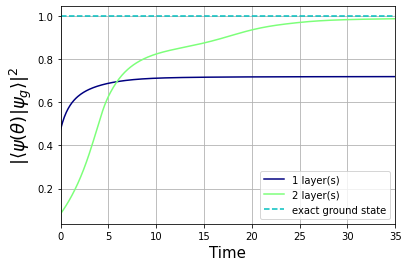

In [60]:
n = 3
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(2):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,35)
#plt.ylim(0.99,1)

plt.savefig("Imaginary_time_evolution_fidelity_over_layers_7qutrits_M=0.1.pdf")

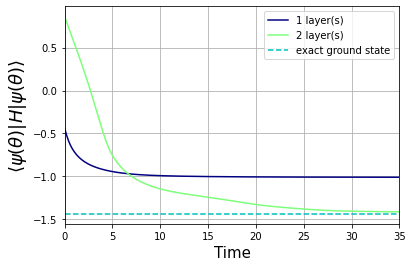

In [61]:
for kkk in range(2):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,35)
#plt.ylim(-0.65,-0.63)

plt.savefig("Imaginary_time_evolution_energy_over_layers_7qutrits_M=0.1.pdf")

###### import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

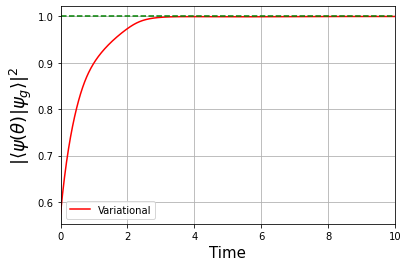

(0.0, 10.0)

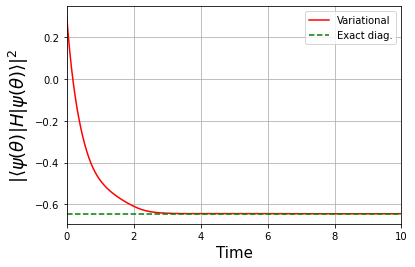

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
